# CS 145 Project 2 | Does Money Grow on Trees? Exploring the Relationship Between Urban Greenery and Property Sale Prices in New York

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Catherine Qing, caqing*
* *Kory Yang, koryyang*

## Project Overview

---

[Research]() has found that in 92% of US cities, low-income neighborhoods have less tree cover than high-income neighborhoods. As a result, we are interested in further exploring disparities in tree cover. Our central question involves examining the relationship between trees (e.g., amount of trees, type of trees) and the **property values** values in different areas. Due to the data available and the scope of the project, we are specifically focusing on New York City. We are hoping that this analysis can provide insights on the relationship between urban greenery and property values.

**The primary question we aim to answer is: To what extent can features derived from tree-related data be used to predict sale prices of individual properties?**

To answer this question, we aim to explore the following subquestions:
- How is the number of trees in an area correlated with that area's property values?
- How are different tree species are related to property sale values?
- What characteristics of those species influence that relationship?

---


## Analysis of Dataset

### Setting Up

In [1]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "cs145-project-23-400804"

In [2]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [3]:
# Installations
!pip install -U plotly
!pip install geojson

# Imports
import matplotlib.pyplot as pt
import plotly.express as px
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
from urllib.request import urlopen
import json
import geojson
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 45.1 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


### Helper Functions

This is a helper function used in later sections to plot these metrics on a choropleth map by zip code:

In [4]:
def plot_zipcode_choropleth(metric, df):
  features = []
  for index, row in df.iterrows():
      features.append(
          geojson.Feature(
            properties={
                'zipcode': row['zipcode'],
                'metric': row[metric],
            },
            id=row['zipcode'],
            geometry=json.loads(row['zip_geojson']),
          )
      )

  geojson_data = geojson.FeatureCollection(features=features)

  fig = px.choropleth_mapbox(
    data_frame=df,
    geojson=geojson_data,
    locations='zipcode',
    color=metric,
    color_continuous_scale="viridis",
    range_color=(df[metric].quantile(0.05), df[metric].quantile(0.95)),
    mapbox_style="carto-positron",
    center={"lat": 40.7128, "lon": -74.0060}, # googled the latitude / longitude for new york city
    zoom=8.8,
    labels={metric: metric, 'zipcode': 'Zipcode'},
    title=metric + ' by zipcode'
  )

  fig.show()

---

### Dataset Summary
We are using three datasets for this project:
- `new_york_trees` (BigQuery): Information about street trees in New York City, including data on tree species, location, condition, and other attributes
- `geo_us_boundaries` (BigQuery): Contains tables that have the boundaries of different geospatial areas as polygons and coordinates based on the center point, including zipcodes, counties, and states
- `nyc_housing` ([Kaggle Link](https://www.kaggle.com/datasets/new-york-city/nyc-property-sales)): Concatenated version of the New York City Department of Finance's Rolling Sales dataset; includes information about a year's worth of property sales/transactions in New York (note that although we named this dataset `nyc_housing` in our project, it includes residential and non-residential properties)

### Tree Datasets
The `new_york_trees` dataset has 4 tables. For this project, we will utilize the `tree_census_2015` table because it is the most recent data available. This table is 222.71 MB and contains 683,788 rows. The trees dataset describes documented trees in New York, and includes things like the tree's diameter, its species name, the zipcode it is located in, problems, latitude, longitude, etc. Each tree has a `tree_id`, which is a unique identification number for each tree point. We will use this when counting the trees.

The dataset overall is well-populated with few null values. Since we will be using the zipcode as a foreign key in to join the tree data with the housing dataset, let's run a quick query to check for null or zero values for zipcode to make sure there aren't too many.



In [5]:
%%bigquery --project $project_id

SELECT COUNTIF(zipcode IS NULL OR zipcode = 0) as num_invalid_zips FROM `bigquery-public-data.new_york_trees.tree_census_2015`

Query is running:   0%|          |

Downloading:   0%|          |

num_invalid_zips
0                 0

Looks good!

We will also use the `tree_species` table, which is 11.02 KB and 57 rows. This table includes information about each specis, such as the specie's environmental tolerances, location tolerances, growth rate, and size. This table contains both the species common name and the scientific name. We will use the scientific name as a foreign key to join to the `spc_latin` column in the `tree_census_2015` table, which is the speciess latin name (aka the scientific name).

### New York Property Sales Dataset

The `nyc_rolling_sales` table in the `nyc_housing` dataset has 84,548 rows and is 16.55 MB. This table does not have any primary keys or unique identifiers, since the same property/building can be sold multiple times, so we created our own primary key, `row_id`, which will become apparent in a later section. In addition, this table's `ZIP_CODE` column will act as a foreign key to the national zip code dataset described below.

The rows of this table describe property sales in New York. The columns represent various features of the property and sales, such as borough, building class, zipcode, gross square feet, and more.

There is a [glossary of terms](https://www.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf) for property sales files defining each feature, which we will reference this throughout the rest of this notebook.


#### Analysis of Target Label: Sale Price

First, let's observe the range of values for our target label SALE_PRICE using a box plot with the points plotted.

In [27]:
%%bigquery nyc_rolling_sales --project $project_id
SELECT * FROM `nyc_housing.nyc_rolling_sales`

Query is running:   0%|          |

Downloading:   0%|          |

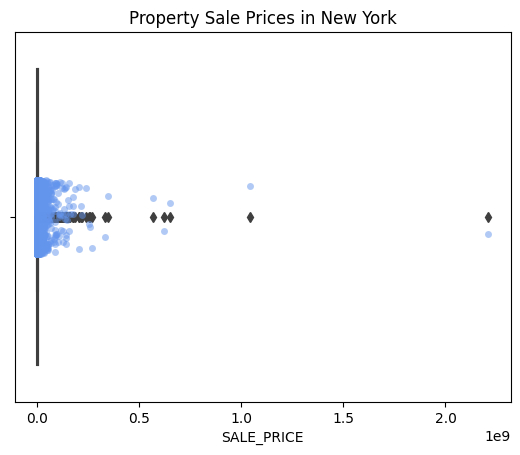

In [96]:
nyc_rolling_sales['SALE_PRICE'] = pd.to_numeric(nyc_rolling_sales['SALE_PRICE'], errors='coerce')
sns.boxplot(x='SALE_PRICE', data=nyc_rolling_sales)
sns.stripplot(x='SALE_PRICE', data=nyc_rolling_sales, color="cornflowerblue", alpha=0.5)
pt.title('Property Sale Prices in New York')
pt.show()

As we see from the plot, we have some extreme outliers. The box plot's interquartile range isn't even noticeable because the data is skewed. It looks like the highest sales price is around 2 billion. Skewed data may be a problem for accuracy of training models. As a result, we'll use the following query to find which rows have the highest sales prices.

In [ ]:
%%bigquery --project $project_id

SELECT *
FROM `nyc_housing.nyc_rolling_sales`
ORDER BY SAFE_CAST(SALE_PRICE AS FLOAT64) DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

int64_field_0  BOROUGH           NEIGHBORHOOD  \
0           7451        1            MIDTOWN CBD   
1           2563        1              FINANCIAL   
2           2561        1              FINANCIAL   
3           6336        1               KIPS BAY   
4           2054        1                FASHION   
5          10038        3  DOWNTOWN-FULTON FERRY   
6           6321        1          JAVITS CENTER   
7           9598        1           MIDTOWN WEST   
8          17110        4       LONG ISLAND CITY   
9           7462        1            MIDTOWN CBD   

                       BUILDING_CLASS_CATEGORY TAX_CLASS_AT_PRESENT  BLOCK  \
0  21 OFFICE BUILDINGS                                            4   1301   
1  21 OFFICE BUILDINGS                                            4     40   
2  21 OFFICE BUILDINGS                                            4     29   
3  08 RENTALS - ELEVATOR APARTMENTS                               2    934   
4  21 OFFICE BUILDINGS                                            4    833   
5  29 COMMERCIAL GARAGES                                          4     54   
6  21 OFFICE BUILDINGS                                            4    732   
7  21 OFFICE BUILDINGS                                            4   1026   
8  27 FACTORIES                                                   4    281   
9  43 CONDO OFFICE BUILDINGS                                          1300   

    LOT EASE_MENT BUILDING_CLASS_AT_PRESENT               ADDRESS  ...  \
0     1                                  O4       245 PARK AVENUE  ...   
1     3                                  O4        60 WALL STREET  ...   
2     1                                  O4       85 BROAD STREET  ...   
3     1                                  D6    460-520 2ND AVENUE  ...   
4    11                                  O4         1250 BROADWAY  ...   
5     1                                  G7         85 JAY STREET  ...   
6    36                                  O3  433-447 NINTH AVENUE  ...   
7    21                                  O5    1706-1720 BROADWAY  ...   
8     1                                  F9   31-00 47TH   AVENUE  ...   
9  1007                                           237 PARK AVENUE  ...   

  RESIDENTIAL_UNITS  COMMERCIAL_UNITS  TOTAL_UNITS  LAND_SQUARE_FEET  \
0                 0                35           35             81336   
1                 0                 1            1             53632   
2                 0                 1            1             42762   
3               894                 8          902            141836   
4                 0                55           55             30750   
5                 0                 0            0            134988   
6                 0                 2            2             39779   
7                 0                 2            2              8848   
8                 0                51           51            120000   
9                 0                 0            0               -     

   GROSS_SQUARE_FEET YEAR_BUILT TAX_CLASS_AT_TIME_OF_SALE  \
0            1586886       1966                         4   
1            1617206       1987                         4   
2             993569       1983                         4   
3             829024       1975                         2   
4             645977       1969                         4   
5                  0          0                         4   
6             350000       1962                         4   
7              52150       1918                         4   
8             568000       1922                         4   
9                -            0                         4   

   BUILDING_CLASS_AT_TIME_OF_SALE  SALE_PRICE                 SALE_DATE  
0                              O4  2210000000 2017-05-05 00:00:00+00:00  
1                              O4  1040000000 2017-01-24 00:00:00+00:00  
2                              O4   652000000 2017-05-24 00:00:00+00:

It looks like the biggest outliers are buildings with a sale price of \$500 million or more. We will exclude these buildings. In addition, it appears that the main buildings skewing the dataset are office buildings, luxury hotels, etc. Let's try using building class at time of sale later to see if we can account for this.

In addition to excluding the outliers identified above, the source of the dataset (see Kaggle link in the Dataset Summary section) mentions that there are a portion of the sales that have nonsensically low sale price values (most commonly, \$0). Those transactions represent deed transfers (e.g., parents transferring ownership to their home to a child). Since our question is to determine whether trees have an effect on a property's value, we can drop those rows, as deed transfers will not be representative of the actual value of the property. We'll start by setting a lower boundary of $10,000, which we'll experiment with changing later.

In addition, we noticed that there were some zipcodes in the dataset with a value of "0", so we will exclude those as well.


In [ ]:
%%bigquery cleaned_nyc_housing_data --project $project_id

SELECT *, SAFE_CAST(SALE_PRICE AS FLOAT64) AS num_sale_price
FROM `nyc_housing.nyc_rolling_sales`
WHERE SAFE_CAST(SALE_PRICE AS FLOAT64) IS NOT NULL AND
      SAFE_CAST(SALE_PRICE AS FLOAT64) > 10000 AND
      SAFE_CAST(SALE_PRICE AS FLOAT64) < 50000000 AND
      ZIP_CODE != 0

Query is running:   0%|          |

Downloading:   0%|          |

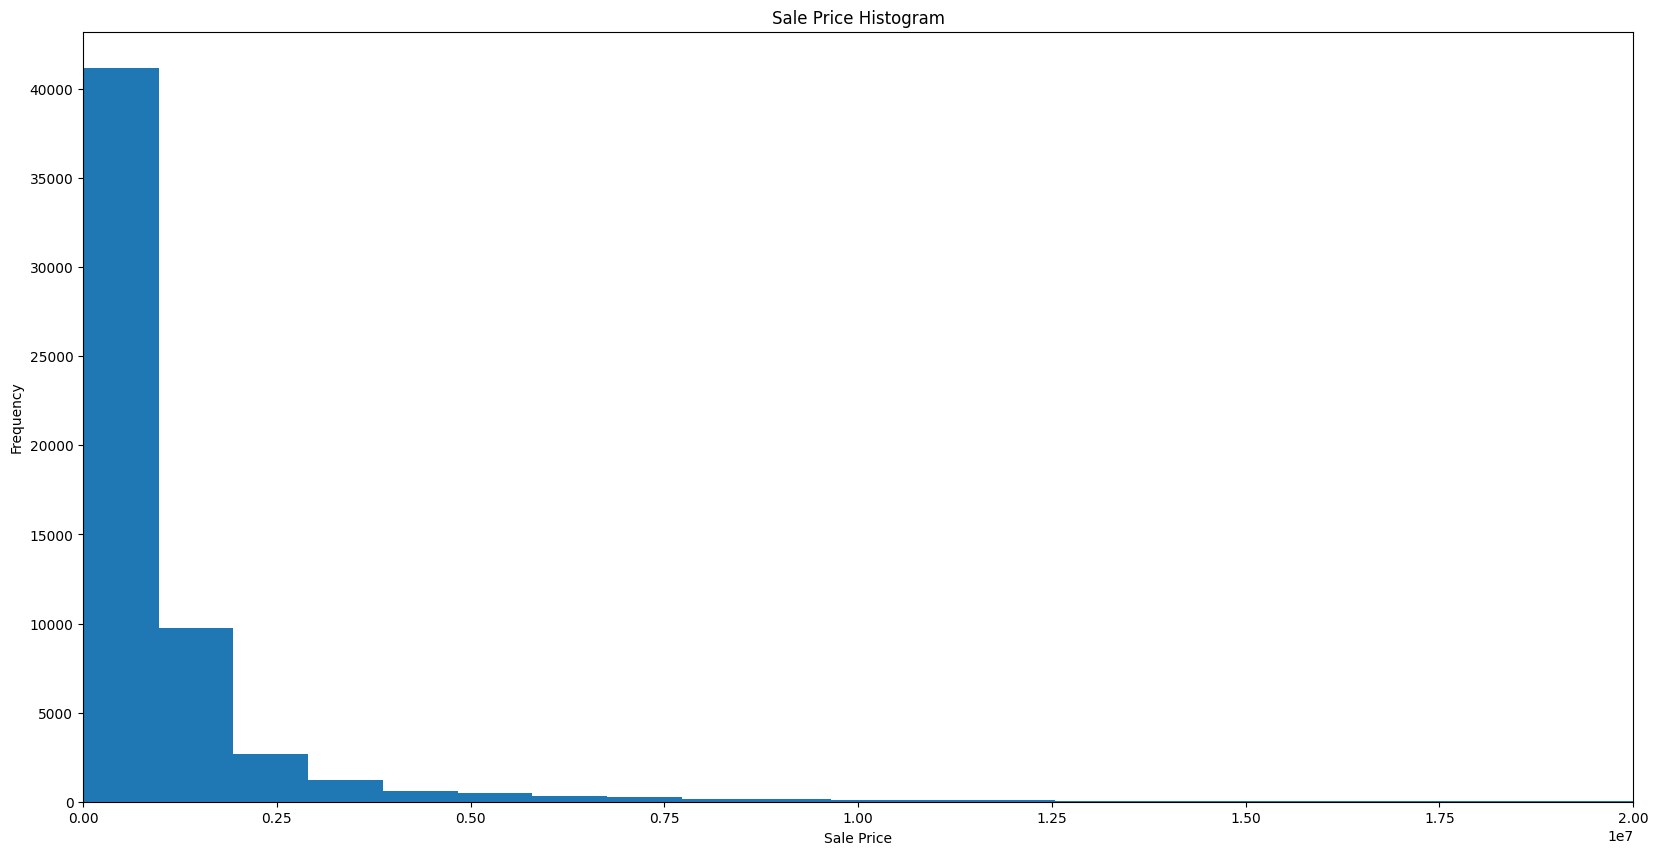

In [ ]:
pt.figure(figsize=(20,10))
pt.hist(cleaned_nyc_housing_data['num_sale_price'], bins=50)

pt.xlim(left=0, right=20000000)
pt.xlabel('Sale Price')
pt.ylabel('Frequency')
pt.title('Sale Price Histogram')
pt.show()

The dataset is still rather skewed, which we'll keep in mind as we go through training and analysis.

#### Data Preprocessing

Let's do some data preprocessing and feature engineering on this table first. We can then run an SQL query and save the cleaned table for future use. Note here that the property sales data does not have any primary keys or unique identifiers, so we created our own primary key: `row_id`.

- `BOROUGH`: Convert from numerical categories into string categories (actual name of the borough)
- `NEIGHBORHOOD`: Included
- `BUILDING_CLASS_CATEGORY`: Included
- `TAX_CLASS_AT_PRESENT`: Included
- `BUILDING_CLASS_AT_PRESENT`: Included, taking the first letter and using that as the class
- `ZIP_CODE`: Remove rows with values of 0 for zip code
- `RESIDENTIAL_UNITS`, `COMMERCIAL_UNITS`, `TOTAL_UNITS`: Remove rows with value of 0 total units and cast to int
- `LAND_SQUARE_FEET`, `GROSS_SQUARE_FEET`: Remove rows with no data and cast to int
- `SALE_DATE`: Split into month and year
- `SALE_PRICE`: Remove rows with low values and NULL values for sale price

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `nyc_housing.cleaned_nyc_housing_data` AS (
  SELECT
    ROW_NUMBER() OVER () AS row_id,
    CASE
      WHEN borough = 1 THEN 'Manhattan'
      WHEN borough = 2 THEN 'Bronx'
      WHEN borough = 3 THEN 'Brooklyn'
      WHEN borough = 4 THEN 'Queens'
      WHEN borough = 5 THEN 'Staten Island'
    END AS borough,
    NEIGHBORHOOD AS neighborhood,
    BUILDING_CLASS_CATEGORY AS building_class_category,
    TAX_CLASS_AT_PRESENT AS tax_class,
    LEFT(BUILDING_CLASS_AT_PRESENT, 1) AS building_class,
    CAST(ZIP_CODE AS STRING) AS zip_code,
    SAFE_CAST(RESIDENTIAL_UNITS AS INT64) AS residential_units,
    SAFE_CAST(COMMERCIAL_UNITS AS INT64) AS commercial_units,
    SAFE_CAST(TOTAL_UNITS AS INT64) AS total_units,
    SAFE_CAST(LAND_SQUARE_FEET AS INT64) AS land_square_feet,
    SAFE_CAST(GROSS_SQUARE_FEET AS INT64) AS gross_square_feet,
    EXTRACT(MONTH FROM SALE_DATE) AS sale_month,
    EXTRACT(YEAR FROM SALE_DATE) AS sale_year,

    SAFE_CAST(SALE_PRICE AS FLOAT64) AS sale_price
  FROM `nyc_housing.nyc_rolling_sales`
  WHERE
    SAFE_CAST(SALE_PRICE AS FLOAT64) IS NOT NULL
    AND SAFE_CAST(SALE_PRICE AS FLOAT64) > 10000
    AND SAFE_CAST(SALE_PRICE AS FLOAT64) < 50000000
    AND ZIP_CODE != 0
    AND SAFE_CAST(RESIDENTIAL_UNITS AS INT64) IS NOT NULL
    AND SAFE_CAST(COMMERCIAL_UNITS AS INT64) IS NOT NULL
    AND SAFE_CAST(TOTAL_UNITS AS INT64) IS NOT NULL
    AND SAFE_CAST(TOTAL_UNITS AS INT64) != 0
    AND SAFE_CAST(GROSS_SQUARE_FEET AS INT64) IS NOT NULL
    AND SAFE_CAST(GROSS_SQUARE_FEET AS INT64) != 0
    AND SAFE_CAST(LAND_SQUARE_FEET AS INT64) IS NOT NULL
    AND SAFE_CAST(LAND_SQUARE_FEET AS INT64) != 0
)

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

### Zipcde Dataset
The primary table we will be using from the `geo_us_boundaries` dataset is the `zip_codes` table because our other datasets also have a zipcode column that we will use to join to this table. This table is 1.19 GB and contains 33,113 rows. However, since we are only considering zip codes in New York, let's get a better idea of what portion of the dataset will be used:

In [ ]:
%%bigquery --project $project_id

SELECT * FROM `bigquery-public-data.geo_us_boundaries.zip_codes` WHERE state_code='NY'

Query is running:   0%|          |

Downloading:   0%|          |

zip_code           city  \
0       14784       Stockton   
1       14728    Dewittville   
2       14724         Clymer   
3       14710       Ashville   
4       14736   Findley lake   
...       ...            ...   
1789    10311  New York city   
1790    11231  New York city   
1791    11433  New York city   
1792    11205  New York city   
1793    10464  New York city   

                                                 county state_fips_code  \
0                                            Chautauqua              36   
1                                            Chautauqua              36   
2                                            Chautauqua              36   
3                                            Chautauqua              36   
4                                            Chautauqua              36   
...                                                 ...             ...   
1789  Bronx County, Kings County, New York County, Q...              36   
1790  Bronx County, Kings County, New York County, Q...              36   
1791  Bronx County, Kings County, New York County, Q...              36   
1792  Bronx County, Kings County, New York County, Q...              36   
1793  Bronx County, Kings County, New York County, Q...              36   

     state_code state_name fips_class_code mtfcc_feature_class_code  \
0            NY   New York              B5                    G6350   
1            NY   New York              B5                    G6350   
2            NY   New York              B5                    G6350   
3            NY   New York              B5                    G6350   
4            NY   New York              B5                    G6350   
...         ...        ...             ...                      ...   
1789         NY   New York              B5                    G6350   
1790         NY   New York              B5                    G6350   
1791         NY   New York              B5                    G6350   
1792         NY   New York              B5                    G6350   
1793         NY   New York              B5                    G6350   

     functional_status  area_land_meters  area_water_meters  \
0                    S        74978431.0           839751.0   
1                    S        69400027.0           121437.0   
2                    S       192445468.0          1523362.0   
3                    S       125262125.0           147055.0   
4                    S        13534656.0                0.0   
...                ...               ...                ...   
1789                 S          121555.0                0.0   
1790                 S         3681946.0            66967.0   
1791                 S         4012839.0                0.0   
1792                 S         2447361.0                0.0   
1793                 S         8993192.0           237116.0   

      internal_point_lat  internal_point_lon            internal_point_geom  \
0              42.311143          -79.385369  POINT(-79.3853695 42.3111433)   
1              42.263333          -79.423176  POINT(-79.4231764 42.2633329)   
2              42.046328          -79.669830    POINT(-79.66983 42.0463283)   
3              42.087770          -79.419847  POINT(-79.4198473 42.0877698)   
4              42.140845          -79.746108  POINT(-79.7461083 42.1408452)   
...                  ...                 ...                            ...   
1789           40.605231          -74.179534  POINT(-74.1795339 40.6052306)   
1790           40.677916          -74.005154  POINT(-74.0051543 40.6779162)   
1791           40.698151          -73.786912  POINT(-73.7869116 40.6981514)   
1792           40.694662          -73.966241  POINT(-73.9662413 40.6946616)   
1793           40.869594          -73.795848  POINT(-73.7958478 40.8695935)   

                                          zip_code_geom  
0     POLYGON((-79.460704 42.327141, -79.460698 42.3...  
1     POLYGON((-79.483438 42.31742, -79.4833

This is about 1794 rows, so if we scale that to the initial table size of 1.19 GB, we are using about 64MB of the table in practice.

## Data Exploration

### Data Preview

In [ ]:
%%bigquery --project $project_id

# Preview of New York trees data
SELECT * FROM `bigquery-public-data.new_york_trees.tree_census_2015` LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

tree_id  block_id  created_at  tree_dbh  stump_diam curb_loc status health  \
0    80548    502982  2015-07-20         0          16   OnCurb  Stump   None   
1   449489    503216  2015-11-12         0           4   OnCurb  Stump   None   
2   449293    503196  2015-11-12         0           5   OnCurb  Stump   None   
3   449153    503188  2015-11-12         0          10   OnCurb  Stump   None   
4   449148    503152  2015-11-12         0           5   OnCurb  Stump   None   

  spc_latin spc_common  ... st_assem st_senate   nta  \
0      None       None  ...       77        32  BX14   
1      None       None  ...       77        29  BX26   
2      None       None  ...       84        29  BX26   
3      None       None  ...       84        29  BX26   
4      None       None  ...       84        29  BX26   

                           nta_name  boro_ct     state   latitude  longitude  \
0  East Concourse-Concourse Village  2018301  New York  40.829143 -73.919927   
1                        Highbridge  2018900  New York  40.833504 -73.930096   
2                        Highbridge  2018900  New York  40.832046 -73.928894   
3                        Highbridge  2018900  New York  40.833093 -73.928451   
4                        Highbridge  2018900  New York  40.832840 -73.929510   

          x_sp         y_sp  
0  1006409.745  241366.4842  
1  1003594.243  242952.9505  
2  1003927.349  242422.1871  
3  1004049.461  242803.4738  
4  1003756.562  242711.2955  

[5 rows x 41 columns]

In [ ]:
%%bigquery --project $project_id

# Preview of housing dataset
SELECT * FROM `cs145-project-23-400804.nyc_housing.nyc_rolling_sales` LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

int64_field_0  BOROUGH NEIGHBORHOOD  \
0            231        1      CHELSEA   
1            232        1      CHELSEA   
2            233        1      CHELSEA   
3            237        1      CHELSEA   
4           1458        1      CLINTON   

                       BUILDING_CLASS_CATEGORY TAX_CLASS_AT_PRESENT  BLOCK  \
0  07 RENTALS - WALKUP APARTMENTS                                2B    770   
1  07 RENTALS - WALKUP APARTMENTS                                 2    770   
2  07 RENTALS - WALKUP APARTMENTS                                2B    772   
3  07 RENTALS - WALKUP APARTMENTS                                2B    790   
4  07 RENTALS - WALKUP APARTMENTS                                 2   1058   

   LOT EASE_MENT BUILDING_CLASS_AT_PRESENT                 ADDRESS  ...  \
0   53                                  C1  222 WEST 21ST   STREET  ...   
1   54                                  C1  224 WEST 21ST   STREET  ...   
2   30                                  C1  229 WEST 22ND   STREET  ...   
3   63                                  C1  148 WEST 15TH   STREET  ...   
4   10                                  C1  441 WEST 48TH   STREET  ...   

  RESIDENTIAL_UNITS  COMMERCIAL_UNITS  TOTAL_UNITS  LAND_SQUARE_FEET  \
0                 9                 0            9              2029   
1                16                 0           16              2927   
2                 8                 0            8              1588   
3                 8                 0            8              2000   
4                12                 0           12              2510   

   GROSS_SQUARE_FEET YEAR_BUILT TAX_CLASS_AT_TIME_OF_SALE  \
0               8540       1920                         2   
1              11580       1920                         2   
2               3600       1910                         2   
3               4100       1910                         2   
4               8175       1901                         2   

   BUILDING_CLASS_AT_TIME_OF_SALE  SALE_PRICE                 SALE_DATE  
0                              C1    29400000 2016-11-10 00:00:00+00:00  
1                              C1         -   2016-11-10 00:00:00+00:00  
2                              C1         -   2016-10-28 00:00:00+00:00  
3                              C1     3485000 2016-12-05 00:00:00+00:00  
4                              C1    12400000 2017-06-28 00:00:00+00:00  

[5 rows x 22 columns]

In [ ]:
%%bigquery --project $project_id
# Preview of zipcode data

SELECT * FROM `bigquery-public-data.geo_us_boundaries.zip_codes` WHERE state_code = "NY" LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

zip_code                                               city  \
0    13640                           Thousand Island Park CDP   
1    14170                                         West falls   
2    12978                                        Redford CDP   
3    13626                                 Copenhagen village   
4    10956  New City CDP, Nanuet CDP, New Square village, ...   

             county state_fips_code state_code state_name fips_class_code  \
0  Jefferson County              36         NY   New York              B5   
1              Erie              36         NY   New York              B5   
2    Clinton County              36         NY   New York              B5   
3      Lewis County              36         NY   New York              B5   
4   Rockland County              36         NY   New York              B5   

  mtfcc_feature_class_code functional_status  area_land_meters  \
0                    G6350                 S        32002948.0   
1                    G6350                 S        31924151.0   
2                    G6350                 S         6769186.0   
3                    G6350                 S       257188879.0   
4                    G6350                 S        41892792.0   

   area_water_meters  internal_point_lat  internal_point_lon  \
0           685333.0           44.346498          -75.928152   
1           138616.0           42.700245          -78.674307   
2                0.0           44.616360          -73.808710   
3           531722.0           43.830086          -75.734774   
4           934833.0           41.157191          -73.993415   

             internal_point_geom  \
0    POINT(-75.928152 44.346498)   
1  POINT(-78.6743075 42.7002448)   
2    POINT(-73.80871 44.6163603)   
3  POINT(-75.7347738 43.8300856)   
4  POINT(-73.9934155 41.1571906)   

                                       zip_code_geom  
0  MULTIPOLYGON(((-75.937516 44.324708, -75.93749...  
1  POLYGON((-78.71812 42.706965, -78.718125 42.70...  
2  POLYGON((-73.829859 44.616192, -73.829948 44.6...  
3  MULTIPOLYGON(((-75.634248 43.841018, -75.63429...  
4  POLYGON((-74.036473 41.155469, -74.037328 41.1...

### Tree Data

Since we plan on using the zipcode field to join this data with the housing sales dataset, all engineered features will be describing properties of the tree dataset aggregated by zip code.

Here is a summary of engineered features that will be covered in this section:
1. Number of trees by zipcode
2. Tree density by zipcode
3. Average tree diameter by zipcode
4. Tree species diversity by zipcode
5. Percent of pollution-tolerant trees by zipcode
6. Percent trees with sidewalk damage by zipcode


#### Tree Count per Zipcode

First, let's take a look at the raw number of trees in each zipcode. We do this by aggregating the number of trees by zipcode, joining the trees table and the zipcode table on zipcode. The results are shown on the map below:

In [ ]:
plot_zipcode_choropleth('num_trees', tree_metrics_by_zipcode)

The primary finding that stands out from this map is that many of the zipcodes that are larger in area have greater numbers of trees. That makes sense, but this tells us that we should also take the square footage of the zipcode into account.

Before we take a look at that in the next section, let's first plot the number of trees and the average housing sale price on a scatterplot using the following query.

In [6]:
%%bigquery num_trees_avg_sale_price_by_zip --project $project_id

SELECT trees.zipcode, COUNT(trees.tree_id) as num_trees, sales.avg_price
FROM `bigquery-public-data.new_york_trees.tree_census_2015` trees
JOIN (
  SELECT s.ZIP_CODE as zipcode, AVG(SAFE_CAST(s.SALE_PRICE AS INT64)) as avg_price
  FROM `nyc_housing.cleaned_nyc_housing_data` s
  GROUP BY zipcode
  ORDER BY avg_price DESC
) AS sales
ON CAST(sales.zipcode AS INT64) = trees.zipcode
GROUP BY trees.zipcode, sales.avg_price
ORDER BY sales.avg_price DESC

Query is running:   0%|          |

Downloading:   0%|          |

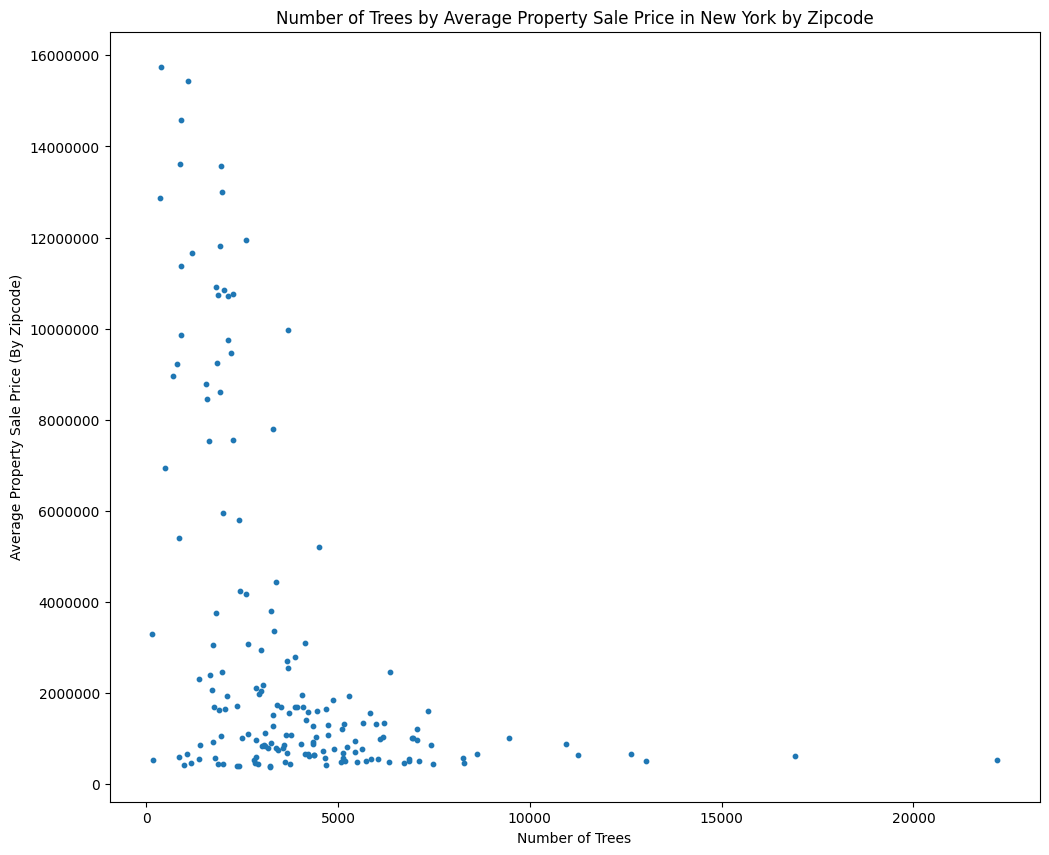

In [95]:
pt.figure(figsize = (12, 10))
pt.xlabel("Number of Trees")
pt.ylabel("Average Property Sale Price (By Zipcode)")
pt.ticklabel_format(style='plain')
pt.title("Number of Trees by Average Property Sale Price in New York by Zipcode")
pt.scatter(num_trees_avg_sale_price_by_zip.num_trees, num_trees_avg_sale_price_by_zip.avg_price, s=10)

From this scatterplot, we can actually see an association between a lower number of trees in a zipcode and lower average property values. Most of the points being clustered in the lower left quadrant suggests that most zipcodes in New York have both a low number of trees as well as low average property values.

However, despite this, there are quite a number of datapoints representing areas with higher property values with a small number of trees. This could be due to the influence of other value drivers. For example, some zipcodes could have other desirable features unrelated to trees that boost property values, such as being a waterfront property or having close proximity to major amenities. There are also wealthy neighborhoods without many trees, as those buildings may have other features or characteristics that buyers may prioritize other than urban greenery.

#### Tree Density per Zipcode



Taking into account the results of the chloropleth map above of the number of trees, we realize it's important to not just count the number of trees in each zipcode, but also look at the number of trees divided by the square footage of land in that zipcode. This will be a metric we call **“tree density”** that may provide us a more accurate picture. Below, we use tree density in another chloropleth map.

In [ ]:
plot_zipcode_choropleth('tree_density', tree_metrics_by_zipcode)

On this map, we can see that areas with higher tree density include zipcodes in the Upper East Village, Upper West Village, and West Village. Upper East Village and Upper West Village are close to Central Park, so it makes sense that there are more trees there. Areas with lower tree density include zipcodes in Harlem, as well as several different areas in the Bronx, such as Mott Haven and Hunts Point.

Many of these neighborhoods are commonly associated with being either affluent or low-income—for instance, the Upper East Village is known for being one of New York's most affluent neighborhoods with tree-lined streets and designer boutiques, while Mott Haven is known for being a lower-income neighborhood. However, we should examine the data more closely to see how property values in each zipcode, which is one indicator of socioeconomic status, look across the city.

To do so, let's create a chloropleth map of average property sale prices for each zipcode in New York in order to compare to the tree density map above.

In [ ]:
%%bigquery sales_ny --project $project_id

SELECT sales.ZIP_CODE as zipcode, AVG(SAFE_CAST(sales.SALE_PRICE AS INTEGER)) as avg_price, ST_ASGEOJSON(zips.zip_code_geom) AS zip_geojson
FROM `bigquery-public-data.geo_us_boundaries.zip_codes` zips
JOIN `cs145-project-23-400804.nyc_housing.cleaned_nyc_housing_data` sales
ON zips.zip_code = sales.ZIP_CODE
GROUP BY zipcode, zip_geojson

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
plot_zipcode_choropleth('avg_price', sales_ny)

*Note*: in both maps, we utilized the 5th and 95th percentile values for the color range rather than minimum and maximum values in order to better highlight the variations in the middle range.

We see some similarities here between the property sale price map and the tree density map. For instance, zipcodes surrounding Central Park that we saw with higher tree density also have high average property prices (around or above \$10 million).

However, there are also some differences. For example, the average housing price in areas at the southern tip of Manhattan are quite high (e.g., zipcodes 10013, 10007), yet they don't have a high tree density.

For a more direct comparison, let's look at how tree density and average housing sale prices are correlated with a scatterplot.

In [10]:
%%bigquery density_sales --project $project_id

WITH treeDensity AS (
    SELECT t.zipcode AS zipcode, t.num_trees / zips.area_land_meters AS tree_density
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes` zips
    JOIN (
        SELECT trees.zipcode, COUNT(trees.tree_id) as num_trees
        FROM `bigquery-public-data.new_york_trees.tree_census_2015` trees
        GROUP BY trees.zipcode
    ) AS t
    ON t.zipcode = CAST(zips.zip_code AS INTEGER)
  )

SELECT treeDensity.tree_density AS tree_density, AVG(SAFE_CAST(s.SALE_PRICE AS FLOAT64)) as avg_price, CAST(s.ZIP_CODE AS STRING) AS zipcode
FROM `nyc_housing.cleaned_nyc_housing_data` s
JOIN treeDensity
ON CAST(s.zip_code AS INT64) = treeDensity.zipcode
GROUP BY tree_density, zipcode

Query is running:   0%|          |

Downloading:   0%|          |

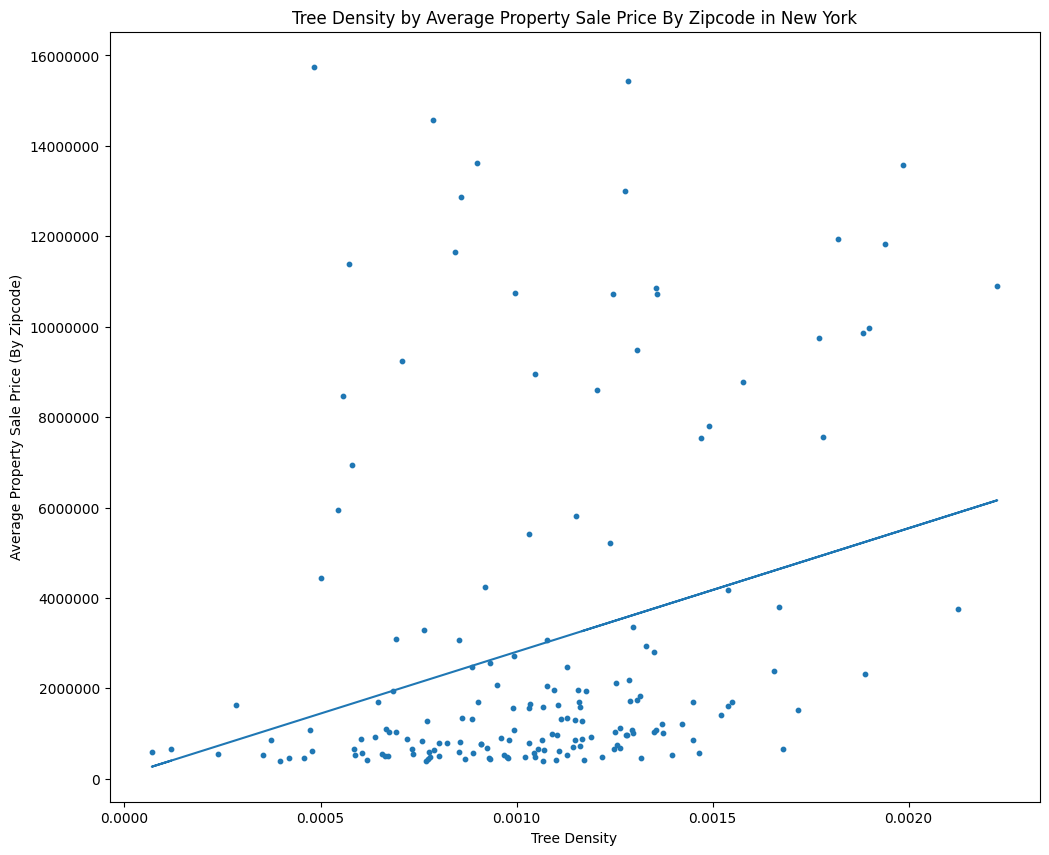

In [11]:
pt.figure(figsize = (12, 10))
pt.xlabel("Tree Density")
pt.ylabel("Average Property Sale Price (By Zipcode)")
pt.ticklabel_format(style='plain')
pt.title("Tree Density by Average Property Sale Price By Zipcode in New York")
pt.scatter(density_sales.tree_density, density_sales.avg_price, s=10)

# add line of best fit
fit = np.polyfit(density_sales['tree_density'], density_sales['avg_price'], 1)
line = np.poly1d(fit)
pt.plot(density_sales['tree_density'], line(density_sales['tree_density']))

We see here that there appears to be a slight upward trend, although there is still some randomness.

#### Average Tree Diameter per Zipcode

The tree count also doesn't account for the size of each individual tree. Since individual tree size data is available to us as tree diameter, let's look at the average diameter for trees in each zip code:

In [ ]:
plot_zipcode_choropleth('avg_tree_diam', tree_metrics_by_zipcode)

The average tree diameter actually seems lower in areas with high property prices. It could be that in urban areas where the sales price appear to be highest, the trees in urban areas are smaller on average. Let's try plotting the average tree diameter by sales price and see if there's a trend:

In [13]:
%%bigquery tree_diam_vs_sales_price --project $project_id

WITH tree_metrics_by_zipcode AS (
  SELECT t.zipcode, t.num_trees, t.avg_tree_diam, t.num_trees / zips.area_land_meters AS tree_density, ST_ASGEOJSON(zips.zip_code_geom) AS zip_geojson
  FROM `bigquery-public-data.geo_us_boundaries.zip_codes` zips
  JOIN (
    SELECT trees.zipcode, COUNT(trees.tree_id) as num_trees, AVG(trees.tree_dbh) as avg_tree_diam
    FROM `bigquery-public-data.new_york_trees.tree_census_2015` trees
    GROUP BY trees.zipcode
  ) AS t
  ON t.zipcode = CAST(zips.zip_code AS INTEGER)
)

SELECT s.zip_code, t.avg_tree_diam, AVG(s.sale_price) as avg_sale_price_by_zip
FROM `nyc_housing.cleaned_nyc_housing_data` s
JOIN tree_metrics_by_zipcode t
ON CAST(s.zip_code AS INT64) = t.zipcode
GROUP BY s.zip_code, t.avg_tree_diam

Query is running:   0%|          |

Downloading:   0%|          |

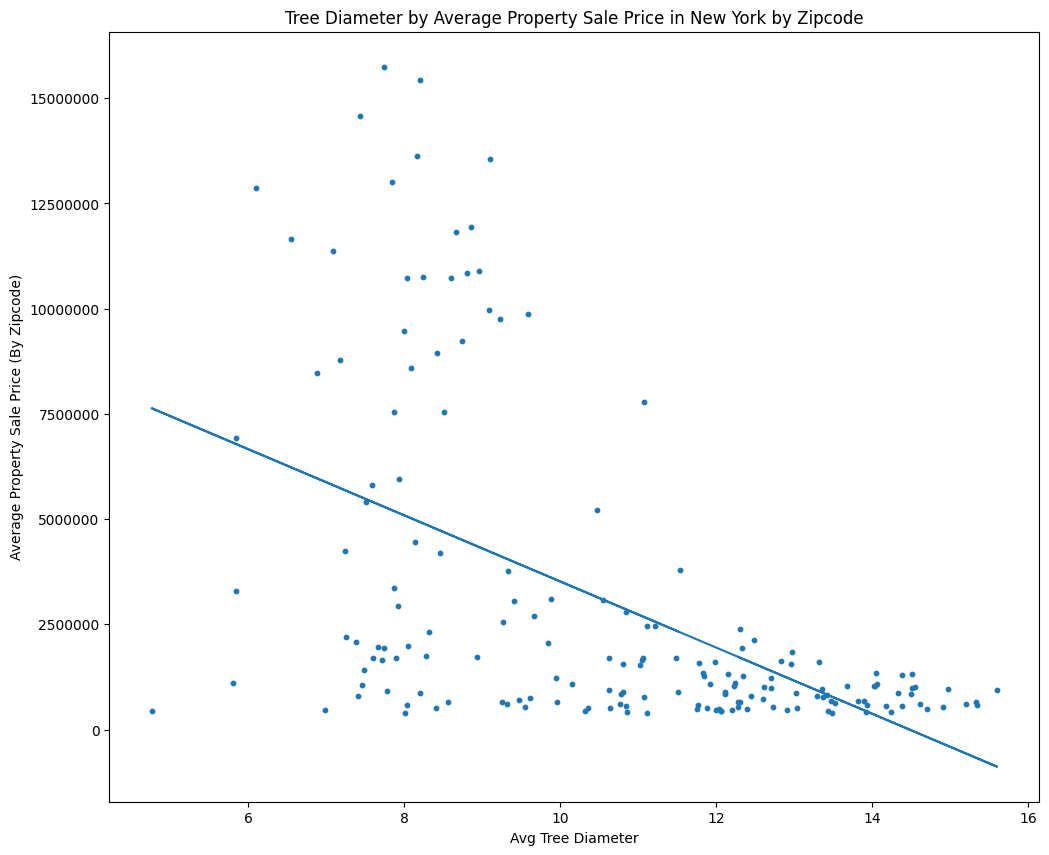

In [94]:
pt.figure(figsize = (12, 10))
pt.xlabel("Avg Tree Diameter")
pt.ylabel("Average Property Sale Price (By Zipcode)")
pt.ticklabel_format(style='plain')
pt.title("Tree Diameter by Average Property Sale Price in New York by Zipcode")
pt.scatter(tree_diam_vs_sales_price.avg_tree_diam, tree_diam_vs_sales_price.avg_sale_price_by_zip, s=10)

# add line of best fit
fit = np.polyfit(tree_diam_vs_sales_price['avg_tree_diam'], tree_diam_vs_sales_price['avg_sale_price_by_zip'], 1)
line = np.poly1d(fit)
pt.plot(tree_diam_vs_sales_price['avg_tree_diam'], line(tree_diam_vs_sales_price['avg_tree_diam']))

As theorized earlier with the chloropleth map, there is a relatively apparent negative correlation between average tree diameter and average property value by zipcode. We see that, generally, areas with higher average property sale prices have smaller tree diameters on average. This is a bit surprising, but one potential explanation could be that those areas have more resources to acquire newly planted trees that are still young/not mature. In addition, areas with low average property values may not keep up with tree maintenance costs as much, leading to more older or overgrown trees. We'll see how well this feature performs in training later.

#### Tree Species Diversity By Zipcode

The features we explored so far have captured data about the number of trees and tree density using the square footage of the zipcodes. However, we haven't yet examined is tree species, which is a promising area for exploration.

We want to explore whether a zipcode with a more diverse spread of tree species can be used as a feature to predict housing prices. Some possible reasons are:
- Being able to have different types of trees in a zipcode could indicate that the government in that area has more money to invest in acquiring and planting a wide variety of trees. In turn, a more well-funded government often correlates with higher property values.
- Having low tree diversity could mean that the land is all the same type (such as in suburbs), which may or may not correlate with higher / lower prices.

To obtain a measure of diversity of a categorical column, we can calculate the [Shannon entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) to characterize how diverse the tree species in a given zip code is. This involves summing the probabilities of each tree species multiplied by its log value, and then the negative of the sum is the entropy. **A higher entropy means higher specie diversity.**

Let's start by inspecting how many null values exist for the species columns:

In [15]:
%%bigquery --project $project_id

SELECT
  COUNTIF(spc_common IS NOT NULL) as spc_common_count,
  COUNT(DISTINCT spc_common) as num_spc_common,
  COUNTIF(spc_latin IS NOT NULL) as spc_latin_count,
  COUNT(DISTINCT spc_latin) as num_spc_latin,
  COUNTIF(zipcode IS NOT NULL AND zipcode != 0) as zip_code_count,
  COUNT(DISTINCT zipcode) as num_zip_code,
  COUNT(*) as total
FROM `bigquery-public-data.new_york_trees.tree_census_2015`

Query is running:   0%|          |

Downloading:   0%|          |

spc_common_count  num_spc_common  spc_latin_count  num_spc_latin  \
0            652169             132           652169            132   

   zip_code_count  num_zip_code   total  
0          683788           191  683788

Key Takeaways:
- It looks like zipcode is defined for each row in the table.
- There are 683788 - 652169 values where the species is null. We will treat null as its own tree species.

Now, let's calculate the Shannon entropy for tree species per zipcode, based on the number of each tree species in each zipcode. Recall [Shannon entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) is calculated with the following formula:

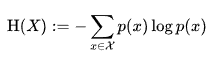

In [16]:
%%bigquery --project $project_id

WITH grouped_tree_species_counts AS (
  SELECT zipcode, spc_latin as species, COUNT(*) AS tree_species_count
  FROM `bigquery-public-data.new_york_trees.tree_census_2015`
  GROUP BY zipcode, spc_latin
),
species_probs_by_zip_code AS (
  SELECT zipcode, species, tree_species_count, tree_species_count / SUM(tree_species_count) OVER (PARTITION BY zipcode) as species_prob
  FROM grouped_tree_species_counts
),
tree_diversity_by_zip_code AS (
  SELECT zipcode, -SUM(species_prob * LOG(species_prob)) AS tree_species_diversity
  FROM species_probs_by_zip_code
  GROUP BY zipcode
)

SELECT * FROM tree_diversity_by_zip_code

Query is running:   0%|          |

Downloading:   0%|          |

zipcode  tree_species_diversity
0      11415                2.924025
1      11697                1.396089
2      11231                3.288547
3      11211                3.040401
4      10026                3.120887
..       ...                     ...
186    10459                3.290479
187    10027                3.066221
188    11354                3.429809
189    11214                3.298042
190    11378                3.357135

[191 rows x 2 columns]

Now let's do a sanity check on the results—an entropy score of zero means there is only one type of tree in that zipcode. A higher entropy score means that the variety of tree species is higher in that zipcode. For checking purposes only, we have picked two arbitrary zip codes from the output above:
- zipcode 11096 has a low entropy score of ~0.84, so it must not be very diverse in terms of tree species.
- zipcode 11433 has a higher entropy score of ~3.25, so it must have a greater number of different species.

In [17]:
%%bigquery --project $project_id

WITH grouped_tree_species_counts AS (
  SELECT zipcode, spc_latin as species, COUNT(*) AS tree_species_count
  FROM `bigquery-public-data.new_york_trees.tree_census_2015`
  GROUP BY zipcode, spc_latin
),
species_probs_by_zip_code AS (
  SELECT zipcode, species, tree_species_count, tree_species_count / SUM(tree_species_count) OVER (PARTITION BY zipcode) as species_prob
  FROM grouped_tree_species_counts
),
tree_diversity_by_zip_code AS (
  SELECT zipcode, -SUM(species_prob * LOG(species_prob)) AS tree_species_diversity
  FROM species_probs_by_zip_code
  GROUP BY zipcode
)

SELECT * FROM grouped_tree_species_counts
WHERE zipcode=11096 OR zipcode=11433
ORDER BY zipcode

Query is running:   0%|          |

Downloading:   0%|          |

zipcode              species  tree_species_count
0     11096               Prunus                   6
1     11096     Quercus coccinea                   2
2     11096    Prunus virginiana                   1
3     11433                 None                 216
4     11433      Zelkova serrata                 167
..      ...                  ...                 ...
86    11433             Magnolia                   1
87    11433         Acer ginnala                   4
88    11433      Prunus serotina                   1
89    11433     Pinus virginiana                   1
90    11433  Chionanthus retusus                   1

[91 rows x 3 columns]

It looks like zipcode 11096 only has 3 different species of trees. Meanwhile, zipcode 11433 seems to have many different species. This means our tree diversity scores should be valid. Now, we can plot this feature with respect to average sale prices by zipcode to see how they are correlated.

In [18]:
%%bigquery tree_diversity_vs_sales_price --project $project_id

WITH grouped_tree_species_counts AS (
  SELECT zipcode, spc_latin as species, COUNT(*) AS tree_species_count
  FROM `bigquery-public-data.new_york_trees.tree_census_2015`
  GROUP BY zipcode, spc_latin
),
species_probs_by_zip_code AS (
  SELECT zipcode, species, tree_species_count, tree_species_count / SUM(tree_species_count) OVER (PARTITION BY zipcode) as species_prob
  FROM grouped_tree_species_counts
),
tree_diversity_by_zip_code AS (
  SELECT zipcode, -SUM(species_prob * LOG(species_prob)) AS tree_species_diversity
  FROM species_probs_by_zip_code
  GROUP BY zipcode
)

SELECT s.zip_code, t.tree_species_diversity, AVG(s.sale_price) as avg_sale_price_by_zip
FROM `nyc_housing.cleaned_nyc_housing_data` s
JOIN tree_diversity_by_zip_code t
ON CAST(s.zip_code AS INT64) = t.zipcode
GROUP BY s.zip_code, t.tree_species_diversity

Query is running:   0%|          |

Downloading:   0%|          |

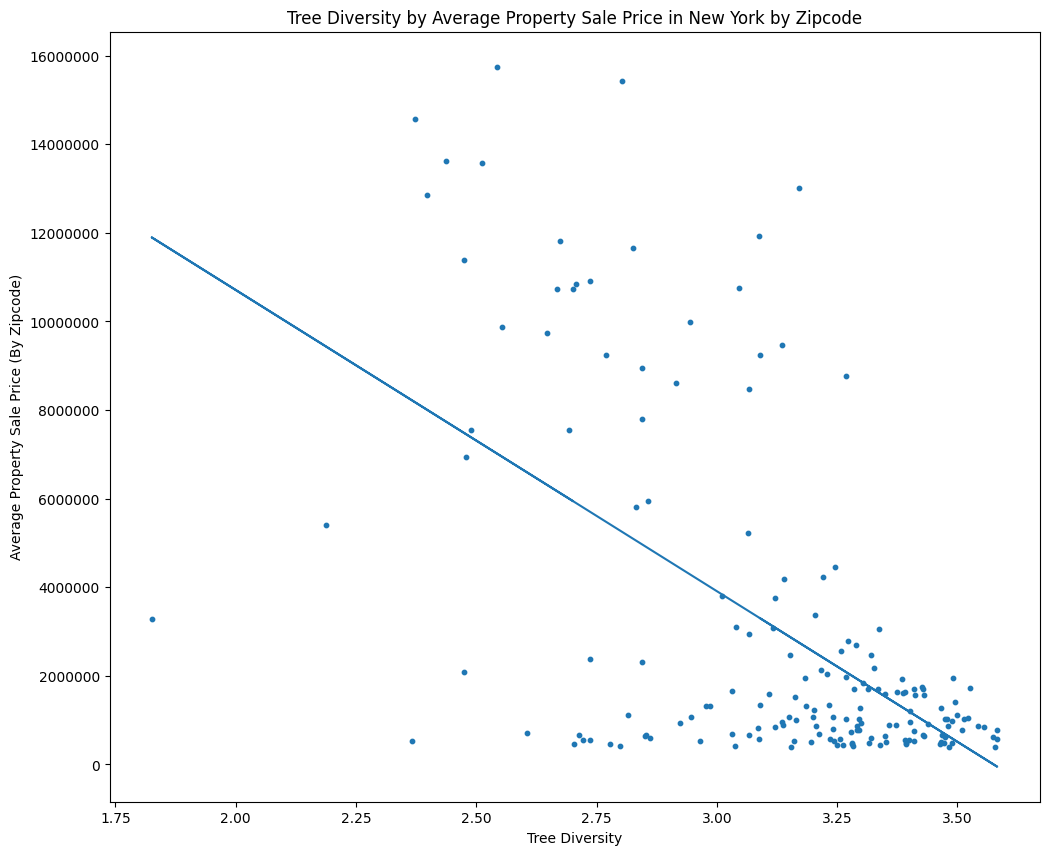

In [93]:
pt.figure(figsize = (12, 10))
pt.xlabel("Tree Diversity")
pt.ylabel("Average Property Sale Price (By Zipcode)")
pt.ticklabel_format(style='plain')
pt.title("Tree Diversity by Average Property Sale Price in New York by Zipcode")
pt.scatter(tree_diversity_vs_sales_price.tree_species_diversity, tree_diversity_vs_sales_price.avg_sale_price_by_zip, s=10)

# add line of best fit
fit = np.polyfit(tree_diversity_vs_sales_price['tree_species_diversity'], tree_diversity_vs_sales_price['avg_sale_price_by_zip'], 1)
line = np.poly1d(fit)
pt.plot(tree_diversity_vs_sales_price['tree_species_diversity'], line(tree_diversity_vs_sales_price['tree_species_diversity']))

Interestingly, we find a negative correlation between tree diversity and housing prices. One reason for this could be that more affluent neighborhoods may have more consistent/uniform and curated landscaping, prioritizing certain tree species for aesthetic purposes. Another potential reason for this is that it has some overlaps with the other features discussed above. For example, having less trees in a given zipcode overall could also mean less biodiversity of the trees. We'll create a heatmap before training to determine which features have multicollinearity. However, this feature does show promise to be used for training our model later on.

#### Pollution Tolerance

Is there something specific about certain trees that are more common in areas with higher housing prices? There are a variety of environmental tolerances listed in the dataset, such as pollution tolerant, salt tolerant, and wet site tolerant. However, given that the tree dataset includes trees from New York, a large and highly populated metropolitan area, we thought the most relevant environmental tolerance to examine would be pollution tolerance.

In [53]:
%%bigquery species_tolerance --project $project_id

SELECT
  tc.zipcode,
  (pollution_count / total_trees) * 100 AS percent_with_pollution_tolerance,
  hp.avg_price
FROM (
  SELECT
    t.zipcode AS zipcode,
    COUNT(t.tree_id) AS total_trees,
    SUM(CASE WHEN s.environmental_tolerances LIKE '%Pollution%' THEN 1 ELSE 0 END) AS pollution_count
  FROM `bigquery-public-data.new_york_trees.tree_census_2015` t
  JOIN `bigquery-public-data.new_york_trees.tree_species` s
  ON t.spc_latin = s.species_scientific_name
  GROUP BY t.zipcode
) tc
JOIN (
  SELECT
    zip_code, AVG(SAFE_CAST(SALE_PRICE AS INTEGER)) AS avg_price
  FROM `nyc_housing.cleaned_nyc_housing_data`
  GROUP BY zip_code
) hp
ON tc.zipcode = CAST(hp.zip_code AS INT64)


Query is running:   0%|          |

Downloading:   0%|          |

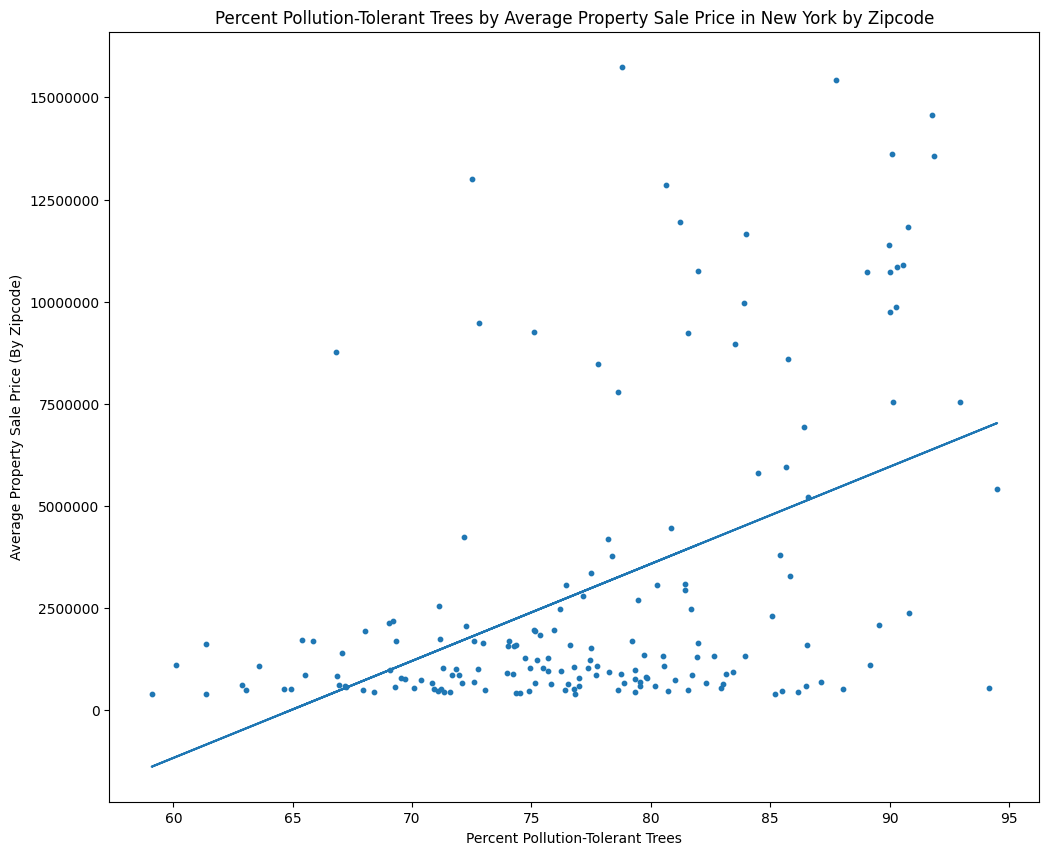

In [92]:
pt.figure(figsize = (12, 10))
pt.xlabel("Percent Pollution-Tolerant Trees")
pt.ylabel("Average Property Sale Price (By Zipcode)")
pt.ticklabel_format(style='plain')
pt.title("Percent Pollution-Tolerant Trees by Average Property Sale Price in New York by Zipcode")
pt.scatter(species_tolerance.percent_with_pollution_tolerance, species_tolerance.avg_price, s=10)

a, b = np.polyfit(species_tolerance.percent_with_pollution_tolerance, species_tolerance.avg_price, 1)
pt.plot(species_tolerance.percent_with_pollution_tolerance, a*species_tolerance.percent_with_pollution_tolerance+b)

There is a general upward trend such that higher percentages of pollution-tolerant trees appear to associated with higher housing prices. This suggests a positive correlation between the percentage of pollution-tolerant trees and housing prices: as the percentage of pollution-tolerant trees increases, there is a tendency for housing prices to also increase. This correlation may imply that areas with more pollution-tolerant trees are perceived as having a cleaner and healthier environment, which might contribute to higher property values.

#### Sidewalk Damage

In [55]:
%%bigquery damage --project $project_id

SELECT
  t.zipcode,
  COUNTIF(t.sidewalk = 'Damage') / COUNT(t.tree_id) * 100 AS percent_damage,
  AVG(SAFE_CAST(s.SALE_PRICE AS INTEGER)) AS avg_price
FROM `bigquery-public-data.new_york_trees.tree_census_2015` t
JOIN  `cs145-project-23-400804.nyc_housing.cleaned_nyc_housing_data` s
ON t.zipcode = CAST(s.zip_code AS INT64)
WHERE t.sidewalk IS NOT NULL
GROUP BY zipcode;


Query is running:   0%|          |

Downloading:   0%|          |

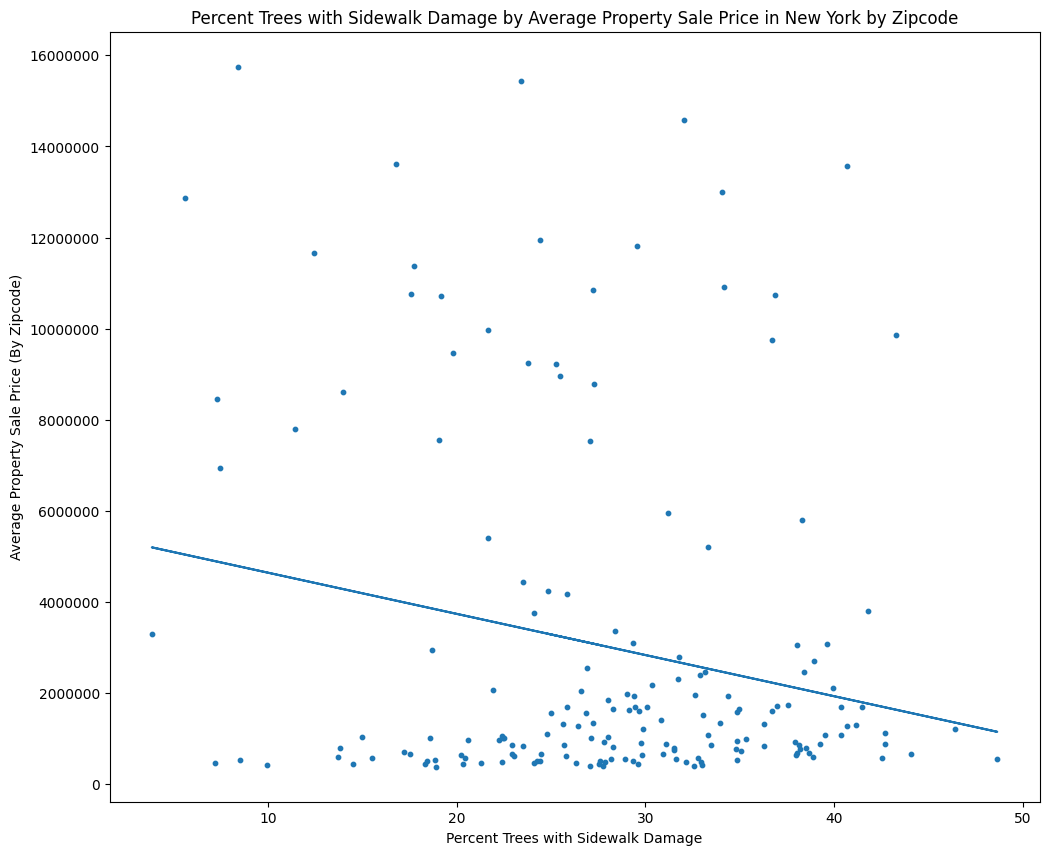

In [91]:
pt.figure(figsize = (12, 10))
pt.xlabel("Percent Trees with Sidewalk Damage")
pt.ylabel("Average Property Sale Price (By Zipcode)")
pt.ticklabel_format(style='plain')
pt.title("Percent Trees with Sidewalk Damage by Average Property Sale Price in New York by Zipcode")
pt.scatter(damage.percent_damage, damage.avg_price, s=10)

a, b = np.polyfit(damage.percent_damage, damage.avg_price, 1)
pt.plot(damage.percent_damage, a*damage.percent_damage+b)

We observe a slight downward trend suggesting that areas with lower average property values have a higher proportion of trees with sidewalk damage near them. This could be because neighborhoods with lower property values could also have limited resources for tree maintenance, leading to more damaged sidewalks near trees. Areas with lower property values may also receive less public investment in maintenance for infrastructure, including sidewalks. However, there is a lot of randomness in this relationship, so this is a very tentative connection between property values and percent of trees with sidewalk damage. Other external factors or variables may be influencing this relationship. For instance, weather-related stress (e.g., storms) could account for relatively high percentage of sidewalk damage across many different zipcodes. In addition, some of these zipcodes, regardless of average property value, could have ongoing construction or development activities that could contribute to sidewalk damage.

#### Summary

In summary, here are the features we've analyzed so far:
- tree count per zipcode
- tree density per zipcode (tree count divided by the square footage of the zipcode in question)
- average tree diameter per zipcode
- tree species diversity per zipcode
- pollution tolerance per zipcode
- sidewalk damage

Tree density appears to have some promise as a feature for predicting property prices in a zipcode since it also encodes the square footage of a zipcode. Smaller zipcodes could mean more urban areas or population-dense, which appear to have higher property sales prices on average. Tree diversity also seems to have potential.

Here, we write out all of the features discussed in this section to a table so that we can join it with the housing sales data. Because our plan is to join the property sales data table by zipcode, all of our features from the tree data are aggregated by zipcode.

In [59]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `nyc_housing.tree_dataset_features` AS (
  SELECT
    zips.*,
    tree_diversity.tree_species_diversity
  FROM (
    SELECT
      t.*,
      t.num_trees / zips.area_land_meters AS tree_density,
      t.pollution_count / t.num_trees AS percent_with_pollution_tolerance,
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes` zips
    JOIN (
      SELECT
        trees.zipcode,
        COUNT(trees.tree_id) as num_trees,
        AVG(trees.tree_dbh) as avg_tree_diam,
        SUM(CASE WHEN s.environmental_tolerances LIKE '%Pollution%' THEN 1 ELSE 0 END) AS pollution_count,
        COUNTIF(trees.sidewalk = 'Damage') / COUNT(trees.tree_id) * 100 AS percent_damage,
      FROM `bigquery-public-data.new_york_trees.tree_census_2015` trees
      JOIN `bigquery-public-data.new_york_trees.tree_species` s
      ON trees.spc_latin = s.species_scientific_name
      GROUP BY trees.zipcode
    ) AS t
    ON t.zipcode = CAST(zips.zip_code AS INTEGER)
  ) AS zips
  JOIN (
    WITH grouped_tree_species_counts AS (
      SELECT zipcode, spc_latin as species, COUNT(*) AS tree_species_count
      FROM `bigquery-public-data.new_york_trees.tree_census_2015`
      GROUP BY zipcode, spc_latin
    ),
    species_probs_by_zip_code AS (
      SELECT zipcode, species, tree_species_count, tree_species_count / SUM(tree_species_count) OVER (PARTITION BY zipcode) as species_prob
      FROM grouped_tree_species_counts
    ),
    tree_diversity_by_zip_code AS (
      SELECT zipcode, -SUM(species_prob * LOG(species_prob)) AS tree_species_diversity
      FROM species_probs_by_zip_code
      GROUP BY zipcode
    )

    SELECT * FROM tree_diversity_by_zip_code
  ) AS tree_diversity
  ON zips.zipcode = tree_diversity.zipcode
)

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [60]:
%%bigquery --project $project_id

-- sanity check to make sure our outputs look ok
SELECT * FROM `nyc_housing.tree_dataset_features` LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

zipcode  num_trees  avg_tree_diam  pollution_count  percent_damage  \
0    10006         48       6.375000               48       29.166667   
1    10111         25       8.160000               25       40.000000   
2    10020         94       6.595745               94       24.468085   
3    11430         37       5.054054               37        0.000000   
4    11697         22       3.454545               22        0.000000   

   tree_density  percent_with_pollution_tolerance  tree_species_diversity  
0      0.000199                               1.0                1.306119  
1      0.002610                               1.0                0.000000  
2      0.001313                               1.0                0.000000  
3      0.000002                               1.0                1.035279  
4      0.000003                               1.0                1.396089

### Property Sales Data

Now, let's explore the New York property sales dataset. As mentioned while exploring the trees dataset, the tree data is connected to this housing dataset by zipcode. We want to predict housing sale price, and multiple properties in the same zipcode can vary wildly. We need to also consider features in the dataset to better predict on a level that is more specific than zipcode.

We will explore various features, starting with the label we're trying to predict, and then we'll select features while doing some visualization of the dataset.

#### Borough

New York City is made up of five boroughs: Manhattan, Bronx, Brooklyn, Manhattan, Queens, and Staten Island. These are the five major governmental districts that compose New York City. Let's see if there could be a relationship between borough and housing prices.

In [23]:
%%bigquery borough_price --project $project_id

SELECT borough, sale_price
FROM `nyc_housing.cleaned_nyc_housing_data`

Query is running:   0%|          |

Downloading:   0%|          |

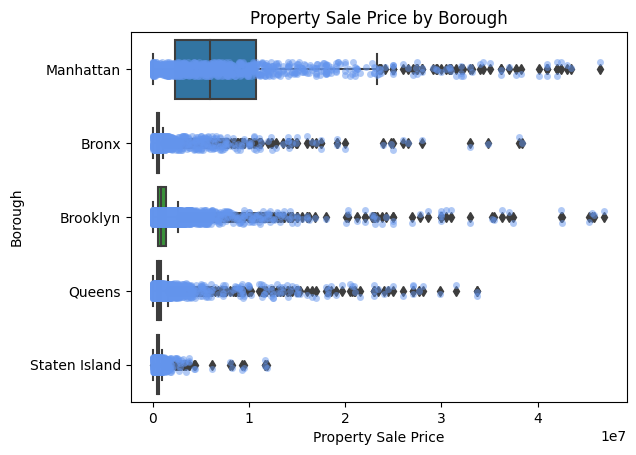

In [25]:
borough_price['sale_price'] = pd.to_numeric(borough_price['sale_price'], errors='coerce')
sns.boxplot(x='sale_price', y='borough', data=borough_price)
sns.stripplot(x='sale_price', y='borough', data=borough_price, color="cornflowerblue", alpha=0.5)
pt.xlabel('Property Sale Price')
pt.ylabel('Borough')
pt.title('Property Sale Price by Borough')
pt.show()

Although the dataset is still skewed, we can clearly see that Manhattan and Brooklyn have higher housing prices on average. This makes sense, as Manhattan and Brooklyn are widely known to have some of the most expensive neighborhoods in New York ([check out this New York Times article!](https://www.nytimes.com/2023/05/04/realestate/most-expensive-neighborhoods-nyc.html)). This indicates that borough may have some potential as a categorical feature for our models.

#### Building Class

According to the glossary of terms linked in the Dataset Summary section, the first letter of each building class describes the general category of the property (e.g. the 'A' in A0 means one family dwellings). For simplicity, we will take the first letter and use that as the category.

#### Other Features

This is a brief summary of all the features from the New York property sales dataset. We mention which features we will be including in the pool of features to *consider* for analysis, and if excluded, a brief justification as to why it was excluded.  

- `BOROUGH`: Included
- `NEIGHBORHOOD`: Included
- `BUILDING_CLASS_CATEGORY`: Included
- `TAX_CLASS_AT_PRESENT`: Included
- `BUILDING_CLASS_AT_PRESENT`: Included
- `ZIP_CODE`: Included
- `RESIDENTIAL_UNITS`, `COMMERCIAL_UNITS`, `TOTAL_UNITS`: Included
- `LAND_SQUARE_FEET`, `GROSS_SQUARE_FEET`: Included
- `SALE_DATE`: Included, split into month and year
- `SALE_PRICE`: Included (target label)

Here are the features we excluded:
- `int64_field_0`: Probably an old ID column; no definition or description of the column exists
- `BLOCK`, `LOT`, `ADDRESS`, `APARTMENT_NUMBER`: Too specific, will be unique per property and unlikely to correlate with property sale price
- `EASE_MENT`: Only has blank values

In [ ]:
%%bigquery cleaned_nyc_housing_data --project $project_id

SELECT * FROM `nyc_housing.cleaned_nyc_housing_data`

Query is running:   0%|          |

Downloading:   0%|          |

## Baseline and Data Prediction

### Generate Features Table / Train, Validation, Test Split

Our features table is generated by joining the property sales dataset to the zipcode dataset by zipcode, as mentioned before.

In addition, we define our training / evaluation / test splits as follows:
- Evaluation set: `row_id`s ending in 1 (10% of data)
- Test set: `row_id`s ending in 0 (10% of data)
- Training set: all other `row_id`s (80% of data)

In [62]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `nyc_housing.features` AS (
  SELECT
    s.*,
    z.num_trees,
    z.avg_tree_diam,
    z.tree_density,
    z.tree_species_diversity,
    z.percent_with_pollution_tolerance,
    z.percent_damage
  FROM `nyc_housing.cleaned_nyc_housing_data` s
  JOIN `nyc_housing.tree_dataset_features` z
  ON s.zip_code = CAST(z.zipcode AS STRING)
)

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

To make our code more efficient later on when we conduct our KNN and regression analyses, we will create three separate tables for the training, evaluation, and test data.

In [63]:
%%bigquery --project $project_id

# Generate training set
CREATE OR REPLACE TABLE `nyc_housing.features_train` AS (
  SELECT *
  FROM `nyc_housing.features`
  WHERE MOD(row_id, 10) > 1
)

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [76]:
%%bigquery --project $project_id

# Generate eval set
CREATE OR REPLACE TABLE `nyc_housing.features_eval` AS (
  SELECT *
  FROM `nyc_housing.features`
  WHERE MOD(row_id, 10) = 1
)

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [77]:
%%bigquery --project $project_id

# Generate Test Set
CREATE OR REPLACE TABLE `nyc_housing.features_test` AS (
  SELECT *
  FROM `nyc_housing.features`
  WHERE MOD(row_id, 10) = 0
)

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [66]:
%%bigquery features_train --project $project_id
SELECT * FROM `nyc_housing.features_train`

Query is running:   0%|          |

Downloading:   0%|          |

In [67]:
features_train.head()

row_id    borough   neighborhood  \
0    1026  Manhattan        CHELSEA   
1   28187  Manhattan  JAVITS CENTER   
2   13846  Manhattan        CHELSEA   
3   27499  Manhattan       FLATIRON   
4    1028  Manhattan        FASHION   

                       building_class_category tax_class building_class  \
0  23 LOFT BUILDINGS                                   4              L   
1  23 LOFT BUILDINGS                                   4              L   
2  26 OTHER HOTELS                                     4              H   
3  23 LOFT BUILDINGS                                   4              L   
4  23 LOFT BUILDINGS                                   4              L   

  zip_code  residential_units  commercial_units  total_units  ...  \
0    10001                  0                19           19  ...   
1    10001                  0                 6            6  ...   
2    10001                  0                 1            1  ...   
3    10001                  0                 4            4  ...   
4    10001                  0                15           15  ...   

   gross_square_feet  sale_month  sale_year  sale_price  num_trees  \
0              45449           2       2017  33000000.0        818   
1             265562          12       2016   5300000.0        818   
2               5260           7       2017   4300000.0        818   
3               3780           5       2017   4650000.0        818   
4              79465          12       2016    220000.0        818   

   avg_tree_diam  tree_density  tree_species_diversity  \
0       7.523227      0.000514                2.474207   
1       7.523227      0.000514                2.474207   
2       7.523227      0.000514                2.474207   
3       7.523227      0.000514                2.474207   
4       7.523227      0.000514                2.474207   

   percent_with_pollution_tolerance  percent_damage  
0                          0.899756       18.459658  
1                          0.899756       18.459658  
2                          0.899756       18.459658  
3                          0.899756       18.459658  
4                          0.899756       18.459658  

[5 rows x 21 columns]

### Selecting Features for Our Model

In order to understand which features have the strongest correlations with sale price, we graph the correlation matrix of the features. This will also help us ensure that we do not select features with high collinearity.

<ipython-input-68-00dd3ed5c079>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(features_train.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)


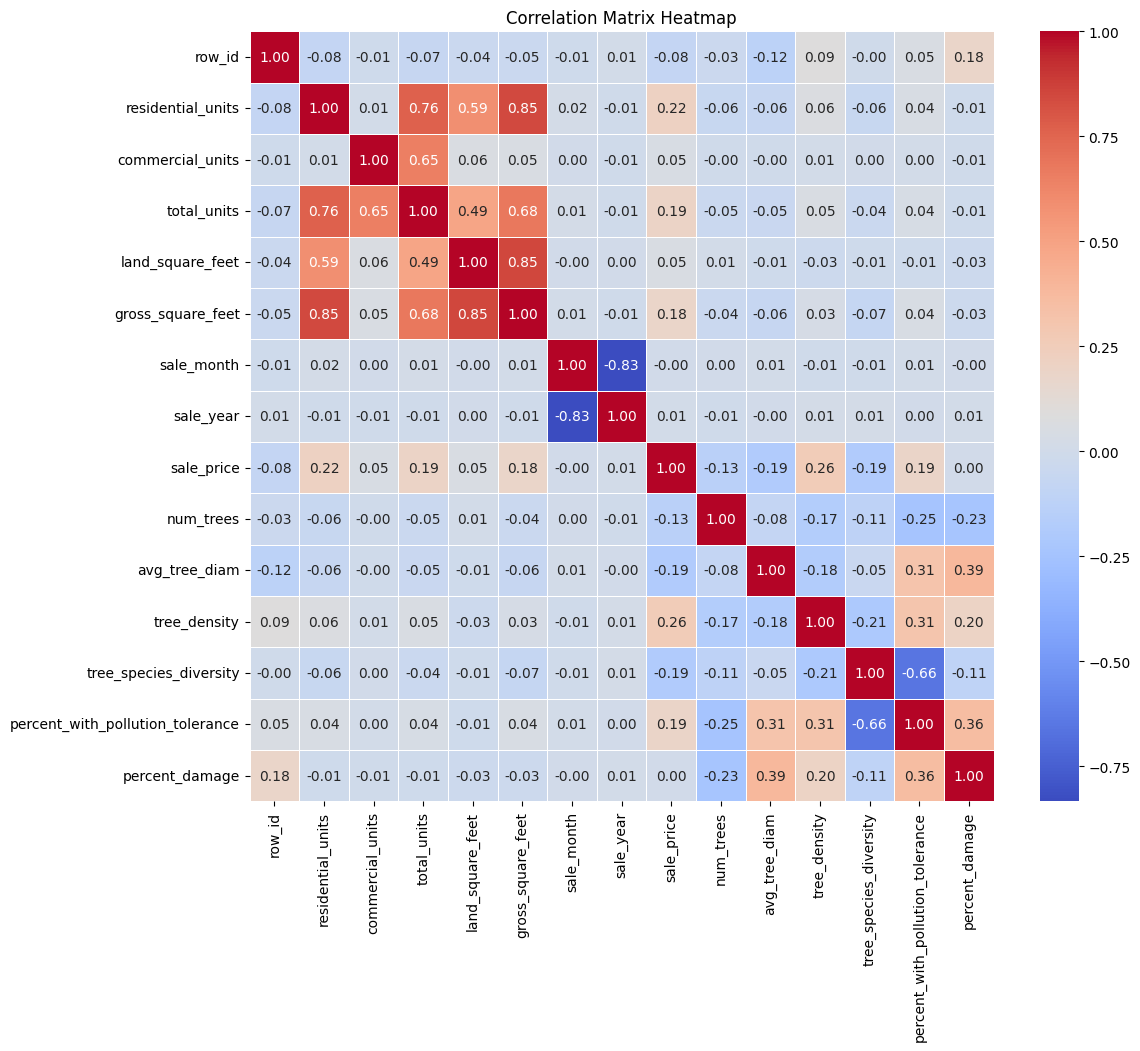

In [68]:
pt.figure(figsize=(12, 10))
sns.heatmap(features_train.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
pt.title('Correlation Matrix Heatmap')
pt.show()

Based on the heatmap, the numeric features that correlate the strongest (relatively) with sale_price are:
- `residential_units`
- `total_units`
- `gross_square_feet`
- `num_trees`
- `avg_tree_diam`
- `tree_density`
- `tree_species_diversity`
- `percent_with_pollution_tolerance`

However, there are some features above that correlate with each other. This is bad for training, as it indicates they cover the same 'space'. For instance, `residential_units`, `gross_square_feet`, and `total_units` all heavily correlate. Intuitively, the more units a property has the more square feet it will have, so this makes sense. We will drop one to two of these features when training. In addition, `percent_damage` has virtually no correlation with sale price, and it is (relatively) strongly correlated with many other tree features, such as `percent_with_pollution_tolerance`, so we will not include it in the models.

Here is the list of features we chose:
- `num_trees`
-`percent_with_pollution_tolerance`
- `tree_density`
- `tree_species_diversity`
- `borough`
- `building_class`
- `total_units`

### Baseline Database Model (KNN)

We calculate the similarity for neighbors using the following features. Every other row is compared to the current row and is given a rank by ordering the potential neighbors over certain properties.

For KNN, we will be using a custom distance function to calculate the nearest neighbor. The custom distance function is a linear combination of the differences between the following features:
- borough
- building_class
- total_units
- num_trees
- tree_density
- tree_species_diversity
- percent_with_pollution_tolerance

For borough and building class, those are categorical features, and cannot be subtracted normally. We calculate their distances by having a distance of 0 if they are the same, and 1.0 / another weight if they are not.

Then, the rest of the numerical features are normalized so they can be appropriately weighted relative to each other. Using the normalized values, we can calculate distance by summing each numerical difference in feature multiplied by a weight. We based how much a feature is weighted on the correlation values displayed in the heatmap above. For instance, `tree_density` and `total_units` correlate slightly more heavily with `sale_price`, so we assign them slightly heavier weights, with weights of 1.1 and 1.2 respectively.

In [78]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `nyc_housing.knn_model_results` AS (
  WITH normalized_features AS (
    SELECT
      row_id,
      sale_price,
      borough,
      building_class,
      total_units / max_total_units AS total_units,
      num_trees / max_num_trees AS num_trees,
      tree_density / max_tree_density AS tree_density,
      tree_species_diversity / max_tree_diversity AS tree_species_diversity,
      percent_with_pollution_tolerance / max_pollution AS percent_with_pollution_tolerance
    FROM `nyc_housing.features`, (
      SELECT
        MAX(total_units) as max_total_units,
        MAX(num_trees) as max_num_trees,
        MAX(tree_density) as max_tree_density,
        MAX(tree_species_diversity) as max_tree_diversity,
        MAX(percent_with_pollution_tolerance) as max_pollution
      FROM `nyc_housing.features`
    )
  ),
  neighbors_ranked AS (
    SELECT
      t1.*,
      neighbor.sale_price AS neighbor_sale_price,
      ROW_NUMBER() OVER (PARTITION BY t1.row_id ORDER BY
        (CASE WHEN t1.borough = neighbor.borough THEN 0.0 ELSE 1.0 END) +
        (CASE WHEN t1.building_class = neighbor.building_class THEN 0.0 ELSE 1.3 END) +
        ABS(t1.total_units - neighbor.total_units) * 1.2 +
        ABS(t1.num_trees - neighbor.num_trees) * 1.0 +
        ABS(t1.tree_density - neighbor.tree_density) * 1.1 +
        ABS(t1.tree_species_diversity - neighbor.tree_species_diversity) * 1.0 +
        ABS(t1.percent_with_pollution_tolerance - neighbor.percent_with_pollution_tolerance) * 1.0
      ) AS neighbor_rank
    FROM (
      SELECT * FROM normalized_features WHERE MOD(row_id, 10) = 1 -- normalized eval set
    ) t1
    CROSS JOIN (
      SELECT * FROM normalized_features WHERE MOD(row_id, 10) > 1 -- normalized train set
    ) neighbor
  )
  SELECT
    num_trees,
    tree_density,
    tree_species_diversity,
    percent_with_pollution_tolerance,
    borough,
    building_class,
    total_units,
    sale_price,
    AVG(neighbor_sale_price) AS predicted_sale_price
  FROM neighbors_ranked
  WHERE neighbor_rank <= 5
  GROUP BY
    num_trees,
    tree_density,
    tree_species_diversity,
    percent_with_pollution_tolerance,
    borough,
    building_class,
    total_units,
    sale_price
)


Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [79]:
%%bigquery knn_model_results --project $project_id

SELECT * FROM `nyc_housing.knn_model_results`

Query is running:   0%|          |

Downloading:   0%|          |

In [80]:
knn_model_results.head()

num_trees  tree_density  tree_species_diversity  \
0   0.049282      0.486396                0.610678   
1   0.087047      0.249755                0.856174   
2   0.569046      0.238156                0.935589   
3   0.307717      0.464226                0.831152   
4   0.134001      0.516433                0.790652   

   percent_with_pollution_tolerance        borough building_class  \
0                          1.000000      Manhattan              D   
1                          0.823228      Manhattan              C   
2                          0.719059  Staten Island              C   
3                          0.888430       Brooklyn              D   
4                          0.894099      Manhattan              C   

   total_units  sale_price  predicted_sale_price  
0     0.045113    318000.0            20573838.8  
1     0.015922  10350000.0             6755000.0  
2     0.006634   2800000.0             1254304.0  
3     0.021230  14000000.0            10812184.2  
4     0.007077   3300000.0             4585000.0

#### KNN Metrics Evaluation

In [81]:
true = knn_model_results['sale_price']
predicted = knn_model_results['predicted_sale_price']

mae = metrics.mean_absolute_error(true, predicted)
mse = metrics.mean_squared_error(true, predicted)
msle = metrics.mean_squared_log_error(true, predicted)
medae = metrics.median_absolute_error(true, predicted)
r2 = metrics.r2_score(true, predicted)
explained_var = metrics.explained_variance_score(true, predicted)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Squared Log Error: {msle}')
print(f'Median Absolute Error: {medae}')
print(f'R-squared (R2): {r2}')
print(f'Explained Variance: {explained_var}')

Mean Absolute Error: 611949.2649174313
Mean Squared Error: 4326328176499.4644
Mean Squared Log Error: 0.441268553726461
Median Absolute Error: 171800.0
R-squared (R2): 0.27972789662411945
Explained Variance: 0.27973510839990967


Our baseline database model yielded an **R2 value of 0.27**, which indicates that the features included in our KNN model are slightly effective at explaining and predicting variations in property sale prices in New York. Overall, our model's goodness of fit is light, as this means about 27% of the variability observed in our target variable (sale price) is explained by our KNN model.

However, it's important to note that there is still quite a bit of variability in house sale prices that is unexplained by the features that were included in our model. Possible reasons for this variability include factors not included in the analysis or the inherent randomness in the data.

Another important metric to note is mean squared error (MSE), but MSE doesn't tell us too much on its own. Thus, we created a naive predictor, shown below, that always predicts the average value of all of the sale prices and then use that to generate a baseline MSE value that we can compare to:

In [82]:
%%bigquery --project $project_id

SELECT
  AVG(POW(sale_price - avg_sale_price, 2.0)) AS mean_squared_error_baseline
FROM (
  SELECT
    AVG(sale_price) AS avg_sale_price
  FROM
    `nyc_housing.features_train`
), `nyc_housing.features_eval`



Query is running:   0%|          |

Downloading:   0%|          |

mean_squared_error_baseline
0                 5.812836e+12

The baseline MSE is significantly larger than the MSE for our KNN model. This suggests that the KNN model performed better than the baseline in terms of the differences between the actual and predicted property values. Essentially, this indicates that our KNN model is more accurate than a naive model that does not consider any features.

### Linear Regression

We will use a combination of several factors to make predictions about housing prices. The training / evaluation / test data is split as discussed previously.

We will test the same set of features that we tested in the KNN model: number of trees, tree density, tree diversity, building class, and total units. We also include borough in this analysis.

#### Model Using Tree-Related Features to Predict Housing Price

In [70]:
%%bigquery --project $project_id

#Train model
CREATE OR REPLACE MODEL `nyc_housing.linear_model`
OPTIONS(model_type='linear_reg') AS
SELECT
  num_trees,
  tree_density,
  tree_species_diversity,
  percent_with_pollution_tolerance,
  borough,
  building_class,
  total_units,
  sale_price AS label
FROM `nyc_housing.features_train`

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [ ]:
%%bigquery --project $project_id

SELECT
*
FROM
ML.TRAINING_INFO(MODEL `nyc_housing.linear_model`)

Query is running:   0%|          |

Downloading:   0%|          |

training_run  iteration          loss     eval_loss  learning_rate  \
0             0          0  2.595654e+12  5.233405e+15            NaN   

   duration_ms  
0         3317

In [83]:
%%bigquery --project $project_id
# Evaluate model
SELECT
  *
FROM
  ML.EVALUATE(MODEL `nyc_housing.linear_model`, (
SELECT
  num_trees,
  tree_density,
  tree_species_diversity,
  percent_with_pollution_tolerance,
  borough,
  building_class,
  total_units,
  sale_price AS label
FROM `nyc_housing.features_eval`
))


Query is running:   0%|          |

Downloading:   0%|          |

mean_absolute_error  mean_squared_error  mean_squared_log_error  \
0        693510.904804        4.091417e+12                 0.71407   

   median_absolute_error  r2_score  explained_variance  
0          274893.077945  0.296042            0.296156

After tweaking around with the feature set with several tree-related features, the above model yielded the best R2 score. An **R2 score of 0.29** indicates a weak correlation between our feature set and the target label. However, the MSE is also lower than the MSE of the naive model that only predicts the mean value of the dataset, meaning that it is outperforming the naive model. The MSE here is also a little lower than the MSE of the KNN model.


Additionally, although our loss value seems high, the metric is scaled to the label being predicted. In our dataet, the label is sale price, which can reach up to hundreds of millions of dollars.

#### Comparison to Linear Regression Model Without Tree-Related Features

To answer our primary question of whether trees can be leveraged as a feature to predict property prices, let's train another linear regression model, but exclude the tree-related features and instead include zipcode. We can evaluate it on our evaluation set and test it on our test set.

In [ ]:
%%bigquery --project $project_id

#Train model
CREATE OR REPLACE MODEL `nyc_housing.linear_model_without_trees`
OPTIONS(model_type='linear_reg') AS
SELECT
  borough,
  building_class,
  total_units,
  sale_price AS label
FROM `nyc_housing.features_train`

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
ML.TRAINING_INFO(MODEL `nyc_housing.linear_model_without_trees`)

Query is running:   0%|          |

Downloading:   0%|          |

training_run  iteration          loss     eval_loss  learning_rate  \
0             0          0  3.669881e+12  2.627129e+12            NaN   

   duration_ms  
0         2717

In [84]:
%%bigquery --project $project_id
# Evaluate model
SELECT
  *
FROM
  ML.EVALUATE(MODEL `nyc_housing.linear_model_without_trees`, (
SELECT
  borough,
  building_class,
  total_units,
  sale_price AS label
FROM `nyc_housing.features_eval`
))


Query is running:   0%|          |

Downloading:   0%|          |

mean_absolute_error  mean_squared_error  mean_squared_log_error  \
0        689363.666757        4.140995e+12                0.628378   

   median_absolute_error  r2_score  explained_variance  
0          255524.425115  0.287512            0.287651

This model's **R2 score is 0.28**. This is about 0.1 lower than the model trained with the tree data, indicating that the model accounting for tree data performs marginally better. The MSE for both are also relatively similar, with the MSE for the model without tree features being a bit larger. This means that the predictions made by the model without tree data deviates more from the true property values.

The marginal increase of 0.1 in the R2 score of the model with tree-related features (versus the model without) indicates a modest improvement in the model's fit with the inclusion of tree features, but this improvement is not substantial. This indicates that tree-related features do not provide significant added value to predicting property value.

To that end, our model using tree-related features to predict property sale price did not perform as well as we originally hoped. However, given the weak correlation between many of the tree-related features and sale price observed in the correlation matrix, it was not surprising. This performance may be because the influence of trees on property prices in New York is just relatively minor. Although green spaces and trees can enhance a neighborhood's visual appeal and lead to health benefits, their impact may not be strong enough to significantly determine property values. Other factors, such as location, neighborhood amenities, proximity to restaurants/nightlife, etc. may outweigh the influence of trees on housing prices.

### Run Best Performing Model on Test Data

The best performing model we observed on the evaluation set was the linear regression model *including the tree-related features*. We will now run that model on the unseen test data.

In [87]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `nyc_housing.linear_model`, (
SELECT
  num_trees,
  tree_density,
  tree_species_diversity,
  percent_with_pollution_tolerance,
  borough,
  building_class,
  total_units,
  sale_price AS label
FROM `nyc_housing.features_test`
))


Query is running:   0%|          |

Downloading:   0%|          |

mean_absolute_error  mean_squared_error  mean_squared_log_error  \
0        712705.887682        4.340288e+12                0.765302   

   median_absolute_error  r2_score  explained_variance  
0          277664.743657  0.300129            0.300195

The linear regression model's **R2 score is 0.30**, with an MSE that is lower than the naive model and the KNN model. This means that approximately 30% of the variability in the predicted sale prices can be explained by the features used in the model. Although these results indicate that our model has moderate predictive/explanatory power, there is certainly much room for improvement. We will elaborate more on the implications of and potential reasons for this outcome in the conclusion.

Here are some of the outputs of the model:

In [85]:
%%bigquery --project $project_id

SELECT
  predicted_label,
  label AS true_label,
  num_trees,
  tree_density,
  tree_species_diversity,
  percent_with_pollution_tolerance,
  borough,
  building_class,
  total_units,
FROM
  ML.PREDICT(MODEL `nyc_housing.linear_model`, (
    SELECT
      num_trees,
      tree_density,
      tree_species_diversity,
      percent_with_pollution_tolerance,
      borough,
      building_class,
      total_units,
      sale_price AS label
    FROM `nyc_housing.features_test`
  ))
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

predicted_label  true_label  num_trees  tree_density  \
0     6.425518e+06  21000000.0       1865      0.001249   
1     6.201964e+06   5000000.0        783      0.000954   
2     6.346598e+06   5100000.0       3055      0.001374   
3     6.365529e+06   1950000.0       2217      0.001318   
4     6.745257e+06  10500000.0       1655      0.001681   
5     6.610863e+06  12500000.0       1836      0.001522   
6     5.464435e+05    341000.0       4335      0.000472   
7     5.464435e+05   1150000.0       4335      0.000472   
8     5.464435e+05    995000.0       4335      0.000472   
9     5.464435e+05    470000.0       4335      0.000472   

   tree_species_diversity  percent_with_pollution_tolerance        borough  \
0                2.706684                          0.902949      Manhattan   
1                2.187870                          0.945083      Manhattan   
2                2.844192                          0.786252      Manhattan   
3                3.138502                          0.782138      Manhattan   
4                2.674242                          0.907553      Manhattan   
5                2.646767                          0.900327      Manhattan   
6                3.398477                          0.700807  Staten Island   
7                3.398477                          0.700807  Staten Island   
8                3.398477                          0.700807  Staten Island   
9                3.398477                          0.700807  Staten Island   

  building_class  total_units  
0              A            1  
1              A            1  
2              A            1  
3              A            1  
4              A            1  
5              A            1  
6              A            1  
7              A            1  
8              A            1  
9              A            1

### KNN and Linear Regression Comparisons

#### Performance

To measure performance, we'll be primarily focusing on the models' R2 scores, as well as their MSEs. This is because MSE is valuable for comparing different models and R2 scores provide a direct measure for explained variability. In addition, because R2 scores are can be sensitive to outliers, it's important to also take into account MSE.

Overall, our KNN model actually performed better than our linear regression model. The R2 score for KNN was 0.38, while the R2 score for the linear regression model was 0.33. This means that the KNN  model has a slightly better fit to the data in comparison to the regression model.

#### Time/Cost

In our case, the time it took to train the linear regression model was much longer than the time it took for our KNN model. Specifically, our KNN model took about 2 seconds, while our linear regression model took 13 seconds to train. As a result, the linear regression model is more costly in terms of time. Due to the nature of KNN comparing to all of its neighbors, we expect the time cost for KNN to increase as the amount of data grows. This indicates that, with more data, it would be more costly (in terms of time) to run KNN than a linear regression model.

Another factor to consider for time cost is that the linear regression model automatically assigns weights to each feature, while we had to manually determine how to assign weights to each feature for KNN, which took a bit more time and thoughtful consideration, and even some trial and error.

#### Cost Analysis

To estimate monetary cost, we searched BigQuery costs and found that 1 TiB (1.1 TB) costs $6.25 ([see here](https://cloud.google.com/bigquery/pricing#analysis_pricing_models)). Our KNN model took 1.85 MB to process, but there is a 10 MB minimum per query, so this query was billed for 10 MB. This makes the monetary cost for our KNN model \$6.25 / 1 TiB * 10 MB, which is about **\$0.00005684**. Our linear regression model took 1.31 MB to process, but this was also rounded up to 10 MB for billing. As a result, the monetary cost is the same as the cost for KNN.

However, it's important to note that KNN would become increasingly costly with more data points because performing joins becomes more expensive with larger amounts of data. If we had 10M or 1B data points, it would be much more costly to run a KNN model in comparison to running a linear regression model. Therefore, KNN is not as scalable to large datasets.

Next, we will calculate the IO costs for each model below.

##### KNN IO Cost Analysis

For the KNN query, we will assume that the construction of the feature table and the normalization of features has occurred already as part of data preprocessing.

First, let's start by evaluating the number of IO's that it will take to generate the neighbors and distances for each one (in our query above, this is the CTE `neighbors_ranked`). The evaluation set table is being cross joined with the train set to determine which rows in the train set are the most similar. The cost of calculating the distances themselves are done in CPU, so it's not part of IO cost.

So the primary IO cost of this section of the query is the JOIN cost. Since it's a cross join, and we must calculate distances for each neighbor in the train set to determine which are the closest, BNLJ seems like the best contender for the IO cost. Sort-Partition Join might seem viable at first, since we need to order and rank each row's neighbors by cost, but the distance metric is not an existing property, so we cannot sort by any existing key beforehand to help this JOIN. Similar logic applies for Hash-Partition Join. Therefore, we will use BNLJ as the join algorithm, and calculate the IO costs:

Let's denote the cost of reading/writing a page as C_r, C_w, respectively. Let's also denote the number of pages in a table R as P(R). Let's assume the page size is 4KB. We will use [BigQuery's info](https://cloud.google.com/bigquery/docs/reference/standard-sql/data-types) on how much each data type is to calculate the sizes of each row.


Each row in our features table has 6 strings, 9 integers, and 5 floats. INT64 and FLOAT64 are both 8 bytes, while strings are variable length (2 bytes + length of encoded string). For simplicity, let's assume strings are on average, 8 bytes. This means each row is 20 * 8 = 160 bytes.

Since we saved our features table, train/eval/test sets to BigQuery as tables, we have numbers on how many rows each one is and can calculate the total size:

```
P(train_set) = (22568 rows * 160 bytes) / 4 KB = 903 pages
P(eval_set) = (2820 rows * 160 bytes) / 4 KB = 113 pages
```

Let's assume RAM is 8GB. The number of pages (B) that fits in RAM is 2000000.

Then taking the formula for IO Cost of BNLJ:

```
C_r * (P(eval_set) + P(train_set) * ceil(P(eval_set) / B)) + C_w * OUT
```

The evaluation set fits in RAM. Therefore, we can sort each row's set of neighbors by their distance features in CPU, and that part won't incur any IO costs.

Assuming C_r and C_w equal 1, like we usually do in class:

```
1 * (113 + 903) + 1 * OUT
```

To find out how many pages OUT is, we need to multiply the row counts of both tables and double the size of the features per row since its a cross join across all features:

```
22568 rows * 2820 rows = 63641760 rows
63641760 * (160 * 2) = 20365363200 bytes -> 20.36 GB
```

The join result doesn't fit in RAM, so we need to account for the IO cost of writing it back.

```
20.36 GB / 4 KB = 5090000 pages
```

So the total cost of the join is:

```
1 * (113 + 903) + 1 * 5090000 = 5091016 IOs
```

Next, we calculate the IO cost of the next section which averages the top 5 ranked neighbors by ascending distance. Let's assume from the previous step that since each partition was ordered by ascending distance, for each row_id's partition, the resulting top ranked neighbors in each partition are next to each other in memory. Since we only consider 5 neighbors, let's assume the relevant neighbor information for each row are on the same page. Then averaging their sale info to generate a prediction can be done in CPU. This means that the IO cost of the predicting section is the IO cost of reading the join result from the previous step.

Let's also assume that just the `row_id` and the predicted label is returned. This would be 16 bytes per row.

```
C_r * (P(join result)) + C_w * OUT
= 1 * (5090000 pages) + 1 * P(num rows in eval set * 160 bytes)
= 5090000 + P(2820 * 16)
= 5090000 + ceil(45120 / 4KB)
= 5090000 + 13
= 5090013 IOs

```

So the total IO cost of the KNN query is:
```
join step cost + calculate step cost
= 5091016 + 5090013
= 10181029 IOs
```

##### Linear Regression IO Cost Analysis

First, we'll calculate the IO cost of training. All of the training calculations are done in CPU. The only IO cost is the cost of reading in the training data, as there is no write cost.
```
C_r * P(train set)
1 * 903 = 903 IOs
```

Now, let's calculate the IO cost of predicting. Assuming the model is stored in RAM, we end up with just the cost of reading the evaluations in.

```
C_r * P(eval set)
1 * 113 = 113 IOs
```

##### Comparing and Analyzing IO Costs

In our project, we observed that our KNN model slightly outperformed our linear regression model. Evidently, the KNN model can be an effective model for interpreting patterns in the data. However, the KNN model had a significantly higher IO cost than the linear regression model. In fact, its IO cost is almost five-fold. This makes sense, as the KNN model involves more extensive data processing as it searches for neighbors for every single data point. This indicates that there is an important tradeoff here: although our KNN model performed better, it was much more resource intensive and less computationally efficient in comparison to our linear regression model.



## Conclusion

### Summary

Our best performing model was our linear regression model with tree-related features. With an R2 score of 0.3, our model demonstrated some ability to predict sale prices, but the set of features utilized in the model were not fully capturing the complexity of the factors that influence property value in New York. The marginal increase in R2 score when using a linear regression model with tree-related features suggests that it has a slightly better fit to the data in comparison to the model without tree-related features. Thus, the inclusion of tree-related features somewhat contributes to explaining the variability in housing prices, but because the improvement is not substantial, we can conclude that tree-related features alone do not strongly determine property prices in New York.

Coming back to our original research question of "To what extent can features derived from tree-related data be used to predict sale prices of individual properties?", our findings suggest that while tree-related features contribute to explaining some variability in property prices, their contribution alone is not substantial. However, our model falls short of suggesting a strong relationship between tree features and property value, as our findings suggest that the tree-related features included in our model have limited predictive power for property sale prices.  Overall, this finding is a bit surprising, given that prior research has found inequities in tree cover across neighborhoods with different incomes. Because we believed property value and income to be related, we were hoping to see that findings about tree cover/urban greenery and income would extend to property value. Ultimately, though, property prices and the real estate market in general are influenced by a myriad of factors. We can conclude that although tree-related features make a small contribution to predicting property sale prices, they are only one part of a much larger, complex picture.

In the process of our analysis, there were also some specific aspects that turned out as expected, such as tree density, which will get higher with a lower zipcode square footage and is slightly correlated with higher property prices. This makes sense, as a zipcode with less square footage overall usually corresponds to urban areas with high demand and high prices (such as in New York City). We also noticed some unexpected things, such as finding that lower average tree diameter in a zipcode corresponded to higher property prices.


### Limitations

The biggest limitation on this data analysis was the lack of specific property location information in the data available.  The data we used did not include the latitude and longitude of the properties themselves. Our analysis was constrained to using the latitude and longitude of each zipcode, but that is much more of a general approximation in comparison to each individual property's location. As a result, we were not able to assess the relationship between the number of trees around a particular property and that property's value. On a similar note regarding zipcode, all of the tree metrics we used to train our model were aggregated by zipcode. Aggregating tree metrics at the zipcode level assumes uniformity within each zipcode, which does not capture potential variations in property values and tree characteristics within the same zipcode. Thus, zipcodes may not be perfectly correlated with property prices, as property values can vary vastly even within the same zipcode.

Another major limitation is that our analysis focused only on the city of New York, so the observed relationships between tree data and property values may be specific to the characteristics or dynamics of this city and may not apply or generalize to other cities. We did find a San Francisco tree dataset, but were unable to find a dataset with property values and sales in San Francisco with a similar set of features. However, it would be important to look beyond just large metropolitan areas and include other areas, such as suburbs, to ensure a representative dataset.

There were also challenges with the property sales dataset itself. The dataset included sale prices for an incredibly wide range of property types. The vast majority of the sale prices were on the lower end with many outliers skewing the dataset. For instance, the highest sale price in this dataset was a skyscraper whose property sale was actually covered in this news article [here](https://therealdeal.com/new-york/2023/06/26/.sl-green-sells-245-park-stake-in-breakthrough-for-office-market/). The large number of outliers made training more difficult.

There was also missing data in certain columns of the property sales data. A sizable chunk of our initial data had to be discarded due to too many missing values. Although the data we ended up using to train the model was cleaner, there was less data, which makes training accurate models more difficult. The trees dataset, while being better in terms of having fewer missing values, is also probably not representative of every single tree in New York. This makes drawing accurate conclusions about the number of trees in a given locale more difficult.


### Future Explorations

Given that New York is just one metropolitan area, if we had more time and resources, we think it would be worthwhile to investigate a broad range of cities to get a more nuanced understanding of the relationship between tree cover and property values across different physical and social/cultural landscapes. Conducting analyses across different cities would enhance the robustness of these findings, and it would provide insight on if the relationships we observed were specific to New York or more consistent across the country. However, it would be difficult to account for various trends of property sale prices from city to city, as well as economic conditions.  

In addition, [research ](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0249715) has found that tree coverage is correlated with factors like race and class due to our country's history of exclusionary zoning laws, segregation, and wealth inequality. We were not able to join our tables to any census datasets due to census data utilizing unique census tracts rather than zipcodes, but our analysis could be more robust with the addition of census data (e.g., demographic data, employment data, income data). If we had more time, we would explore ways to include this data. Perhaps there's another dataset somewhere containing census tracts and the zipcode each is in that would we could use to join all of these tables.  

Finally, another idea for further exploration of this data and problem space involves investigating adding latitude and longitude into the property sales dataset for each property. The dataset we used included an address table; therefore, finding the latitude and longitude is theoretically possible with something like Google Earth's API, but adding thousands of columns using such a lookup is likely not possible without extensive usage of external scripting. Ultimately, though, this would allow for a more granular analysis of each property and the trees nearby, which could yield more valuable insights on the influence of trees on property values.